In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
%matplotlib inline
from datetime import datetime as dt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.cm as cm
from sklearn import linear_model
import json
import logging
FORMAT = '%(asctime)-15s %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)
from sklearn.preprocessing import MinMaxScaler

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


## Section 1 -- Import data

In [3]:
# import csv files with wikipedia pageview info and supporting links
df_wiki = pd.read_csv('wikipedia_links.csv',index_col='wiki_url')
df_wiki_links = pd.read_csv('data/wiki_links_data.csv', index_col='wiki_url')
df_wiki_pageviews = pd.read_csv('data/wiki_pageviews_data.csv', index_col=0)
# import csv file with ratings from both RT and metacritic
df_rt = pd.read_csv('data/rottentomatoes_data.csv', index_col='wiki_url')
df_mc = pd.read_csv('data/metacritic_data.csv', index_col='wiki_url')
# import csv file with bomojo box office information for each
df_bomojo = pd.read_csv('data/bomojo_data.csv', index_col='wiki_url')
# import TheMovieDB data including youtube trailer view data
df_tmdb = pd.read_csv('data/themoviedb_data.csv', converters={'genres':json.loads,'credits':json.loads,
                                                              'keywords':json.loads,'production_companies':json.loads,
                                                              'production_countries':json.loads,
                                                              'video_stats':json.loads},header=0, index_col='wiki_url')
df_tmdb = df_tmdb.drop(['adult', 'backdrop_path', 'belongs_to_collection','facebook_id', 'homepage','instagram_id',
             'original_language', 'original_title','poster_path','spoken_languages', 'status','twitter_id','video'],axis=1)

In [4]:
df_bomojo['release_date'] = pd.to_datetime(df_bomojo.release_date)
df_tmdb['release_date'] = pd.to_datetime(df_tmdb.release_date)
df_wiki_pageviews.index = pd.to_datetime(df_wiki_pageviews.index)

## Section 2 -- Join, feature creation

In [5]:
# need to split genres, keywords, production companies
# video stats into seprate dataframe to group and create features
# pull out production country
# scale vote counts
# remove release date and revenue, get that from bomojo
# might look into tf-idf and clustering with tagline

In [6]:
# split genres, keywords and production companies and countries from column / dictionary
genre_rows = []
for i, genres in zip(df_tmdb.index,df_tmdb.genres):
    if isinstance(genres,list):
        for genre in genres:
            genre_rows.append((i, genre['name']))

df_genre = pd.DataFrame(genre_rows,columns=['wiki_url','genre'])
df_genre.set_index('wiki_url',inplace=True)
df_genre = pd.get_dummies(df_genre).groupby('wiki_url').sum()

In [7]:
keyword_rows = []
for i, keywords in zip(df_tmdb.index,df_tmdb.keywords):
    if isinstance(keywords,list):
        for keyword in keywords:
            keyword_rows.append((i, keyword['name']))

df_keyword_stage = pd.DataFrame(keyword_rows,columns=['wiki_url','keyword'])
df_keyword_stage.set_index('wiki_url',inplace=True)
df_keyword = pd.get_dummies(df_keyword_stage).groupby('wiki_url').sum()

In [8]:
prod_rows = []
for i, prods in zip(df_tmdb.index,df_tmdb.production_companies):
    if isinstance(prods,list):
        for prod in prods:
            prod_rows.append((i, prod['name']))

df_prod_cos = pd.DataFrame(prod_rows,columns=['wiki_url','prod_company'])
df_prod_cos.set_index('wiki_url',inplace=True)
df_prod_cos = pd.get_dummies(df_prod_cos).groupby('wiki_url').sum()

In [9]:
prod_co_rows = []
for i, prods in zip(df_tmdb.index,df_tmdb.production_countries):
    if isinstance(prods,list):
        for prod in prods:
            prod_co_rows.append((i, prod['name']))

df_prod_country = pd.DataFrame(prod_co_rows,columns=['wiki_url','prod_country'])
df_prod_country.set_index('wiki_url',inplace=True)
df_prod_country = pd.get_dummies(df_prod_country).groupby('wiki_url').sum()

In [10]:
credit_rows = []
for i, credits in zip(df_tmdb.index,df_tmdb.credits):
    if isinstance(credits,list):
        for credit in credits:
            credit_rows.append((i, credit['name']))

df_credits = pd.DataFrame(credit_rows,columns=['wiki_url','credit_name'])
df_credits.set_index('wiki_url',inplace=True)
df_credits = pd.get_dummies(df_credits).groupby('wiki_url').sum()

In [11]:
# create dataframe of YT video statistics
video_rows = []
for i, videos in zip(df_tmdb.index,df_tmdb.video_stats):
    if isinstance(videos,list):
        for video in videos:
            if video is not None:
                video['wiki_url'] = i
                video_rows.append(video)

df_video = pd.DataFrame(video_rows)
df_video = df_video.drop(['favoriteCount'],axis=1).set_index('wiki_url')
df_video = df_video.apply(pd.to_numeric)
df_video = df_video.dropna()
df_video = df_video.groupby('wiki_url').agg({'viewCount' : ['count','min','max','mean','median'], 
                                             'commentCount' : ['min','max','mean','median'],
                                             'dislikeCount' : ['min','max','mean','median'],
                                            'likeCount': ['min','max','mean','median']})

In [12]:
# scaling video views
scaler = MinMaxScaler()
df_video[df_video.columns] = scaler.fit_transform(df_video[df_video.columns])

In [13]:
len(video_rows)

6702

In [14]:
df_video.describe()

viewCount                                                      \
             count          min          max         mean       median   
count  3301.000000  3301.000000  3301.000000  3301.000000  3301.000000   
mean      0.013672     0.029114     0.002914     0.006396     0.021796   
std       0.035717     0.067542     0.018348     0.021148     0.047318   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000794     0.000108     0.000350     0.001052   
50%       0.000000     0.004906     0.000554     0.001693     0.005121   
75%       0.014706     0.025780     0.002592     0.006740     0.023038   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

      commentCount                                        dislikeCount  \
               min          max         mean       median          min   
count  3301.000000  3301.000000  3301.000000  3301.000000  3301.000000   
mean      0.008529     0.006667     0.014614     0.012231     0.006343   
std       0.036622     0.032033     0.052169     0.045764     0.035152   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000070     0.000077     0.000273     0.000202     0.000065   
50%       0.000624     0.000526     0.001759     0.001301     0.000446   
75%       0.004220     0.002974     0.008714     0.007285     0.002678   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                                                likeCount               \
               max         mean       median          min          max   
count  3301.000000  3301.000000  3301.000000  3301.000000  3301.000000   
mean      0.001939     0.002875     0.008981     0.006734     0.007328   
std       0.021728     0.022027     0.041395     0.033122     0.038322   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000020     0.000047     0.000163     0.000072     0.000080   
50%       0.000114     0.000272     0.000849     0.000496     0.000507   
75%       0.000686     0.001369     0.004583     0.002967     0.003023   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                                 
              mean       median  
count  3301.000000  3301.000000  
mean      0.011662     0.009880  
std       0.046355     0.040760  
min       0.000000     0.000000  
25%       0.000212     0.000170  
50%       0.001218     0.000949  
75%       0.006155     0.004880  
max       1.000000     1.000000

### Clustering TheMovieDB movie information

In [15]:
def join_dataframes(df1, *others):
    new_df = df1
    for df in others:
        new_df = new_df.merge(df,left_index=True, right_index=True) 
    return new_df

In [16]:
from silhouette_scores import silhouette_scores

For n_clusters = 2 The average silhouette_score is : 0.018689204471828168
For n_clusters = 3 The average silhouette_score is : 0.008345175242856563
For n_clusters = 4 The average silhouette_score is : 0.0016428440981151788
For n_clusters = 5 The average silhouette_score is : 0.0012708458284674481
For n_clusters = 10 The average silhouette_score is : -0.00743273688754833
For n_clusters = 20 The average silhouette_score is : -0.01246232595438146
For n_clusters = 100 The average silhouette_score is : -0.037647316590693425


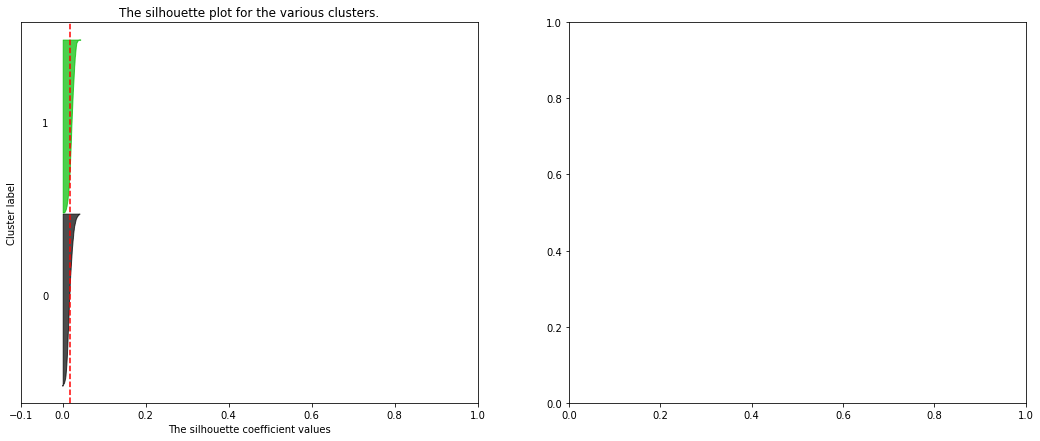

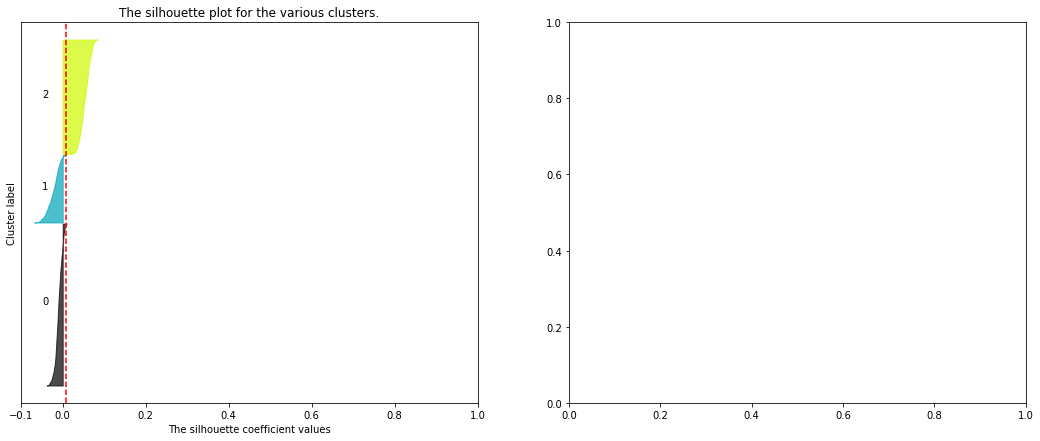

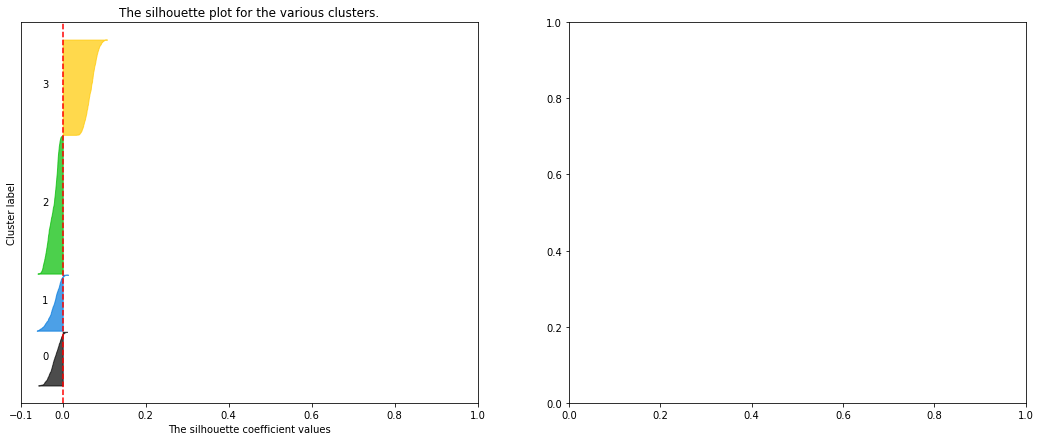

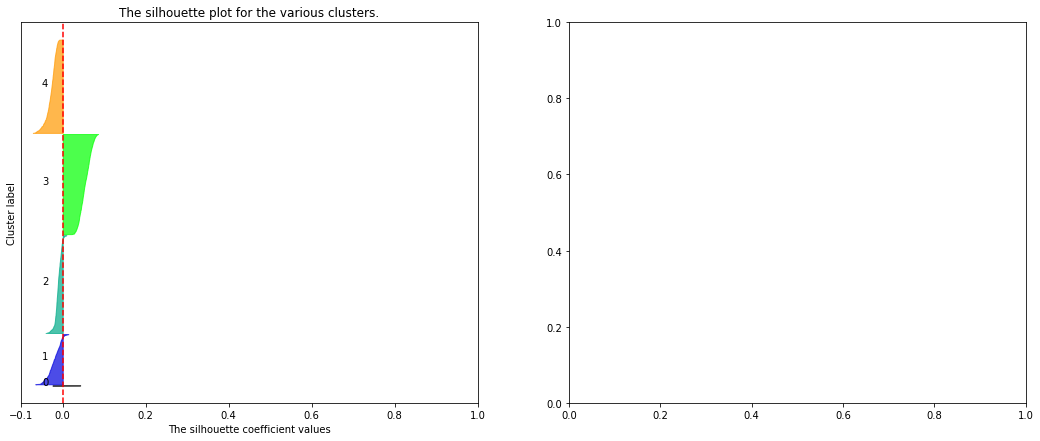

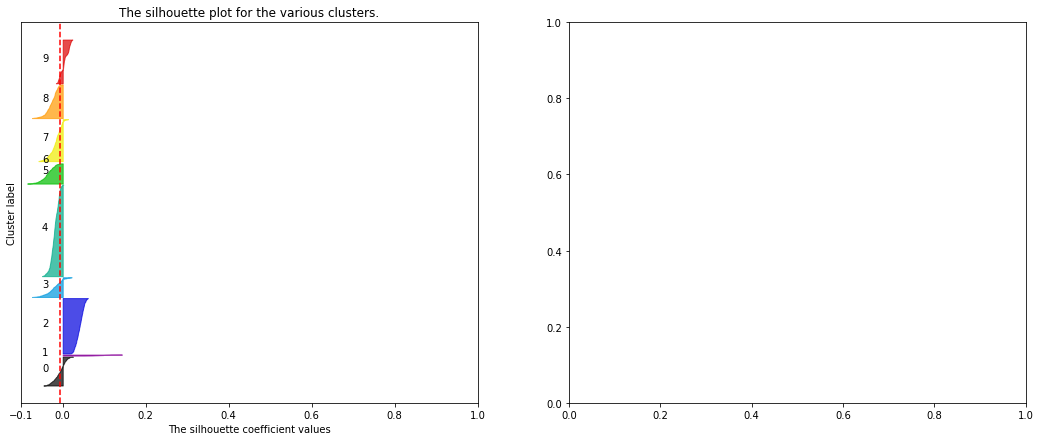

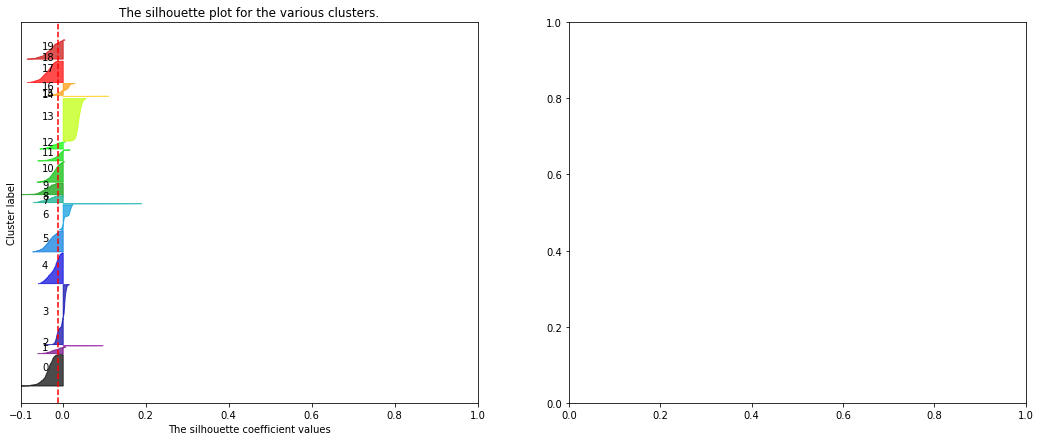

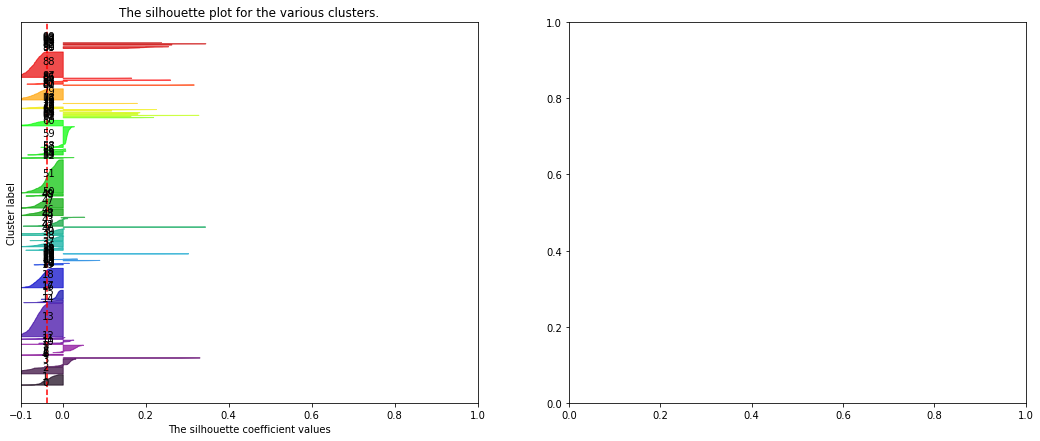

In [17]:
# cluster movie info including credits, keywords, production information
tmdb_cluster = join_dataframes(df_genre,df_prod_cos,df_prod_country,df_keyword,df_credits)
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,10,20,100]

silhouette_scores(tmdb_cluster, range_n_clusters, KMeans)

Tried KMeans and SpectralClustering with n_clusters from 2-150. None of the options provided very good silhouette scores. I also ran the silhouette scores with and without the actor credits, that didn't help much either. 

Other options for using actor credits:
1. Reduce number of actor credits identified - I first tried 10 actors and moved to 5 to try and limit dimensions
2. Use historical box office prior to a film being released to rank actors money-making power
3. Average the money-making power across all the actors in a film prior to release

For n_clusters = 2 The average silhouette_score is : 0.0244810815283566
For n_clusters = 3 The average silhouette_score is : 0.015041909504072432
For n_clusters = 4 The average silhouette_score is : -0.0024481111802774464
For n_clusters = 5 The average silhouette_score is : -0.003783616551884698
For n_clusters = 10 The average silhouette_score is : -0.014599489275115216
For n_clusters = 20 The average silhouette_score is : -0.002620461962920325
For n_clusters = 30 The average silhouette_score is : -0.013739216003807
For n_clusters = 100 The average silhouette_score is : -0.017967064319236194


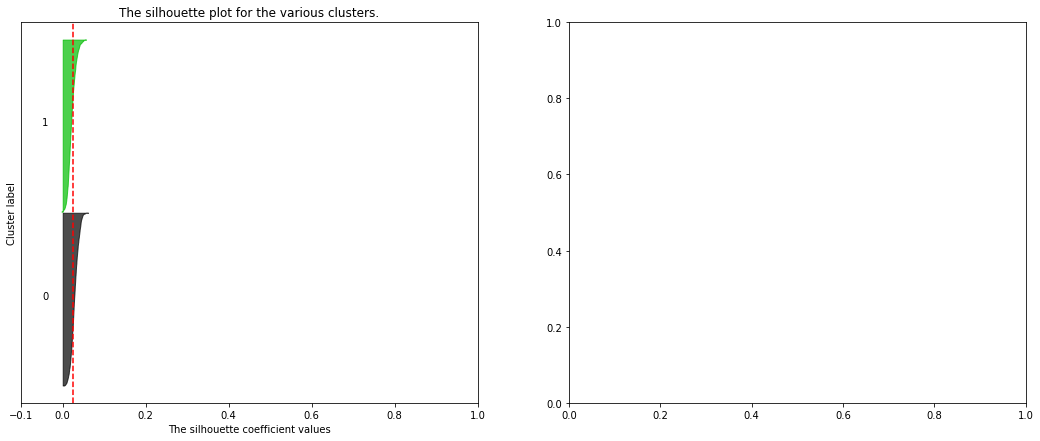

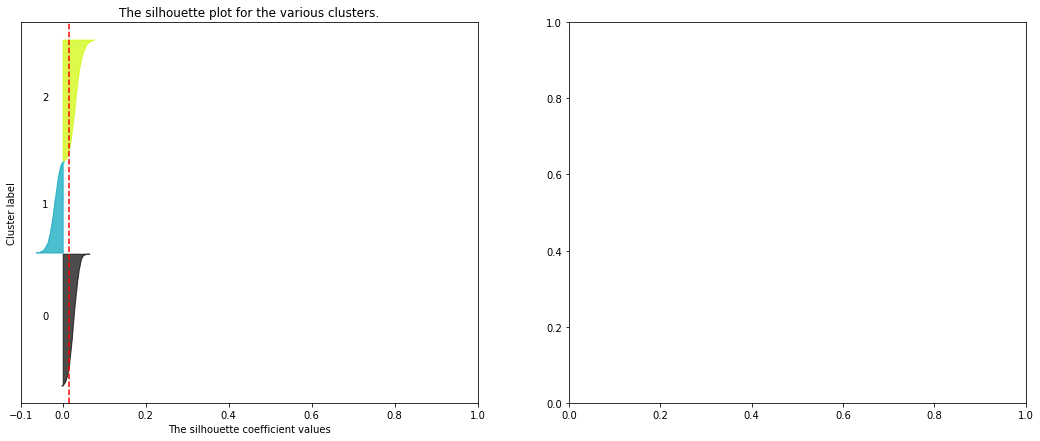

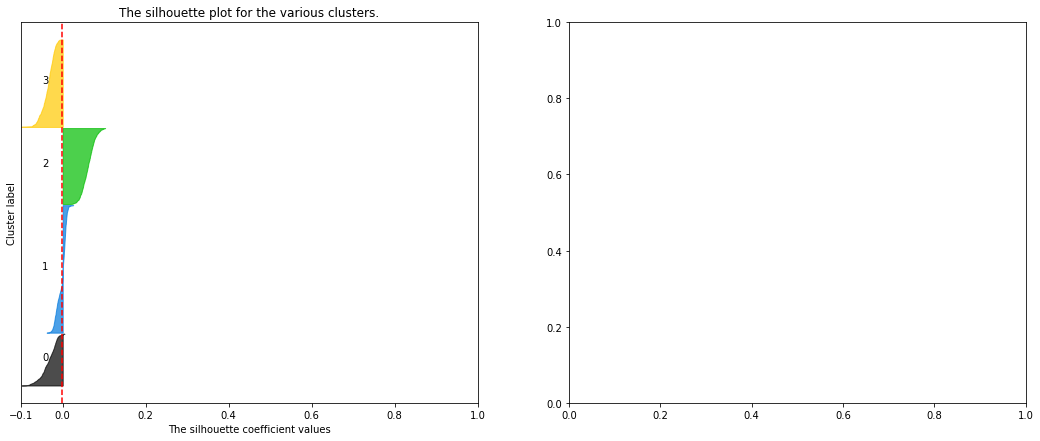

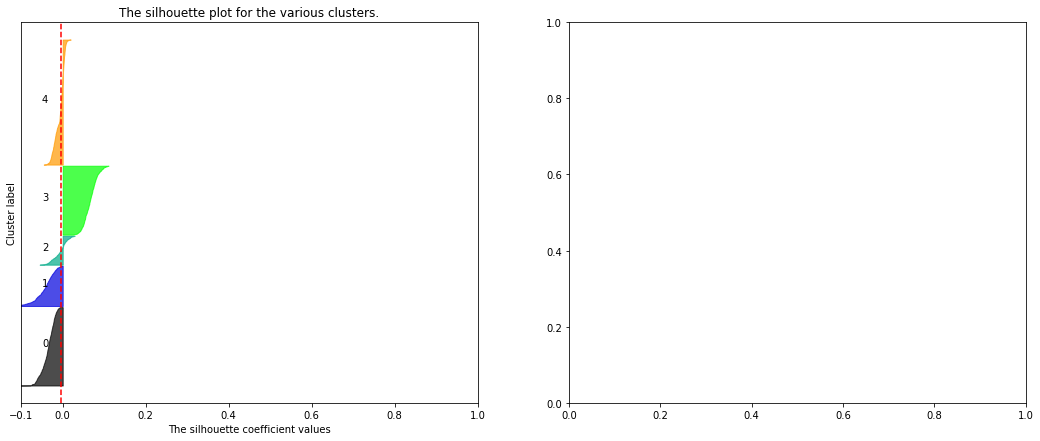

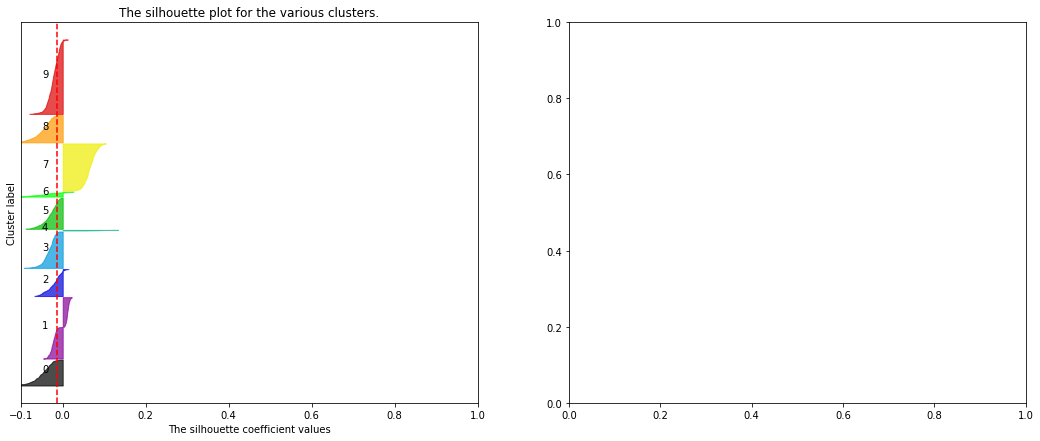

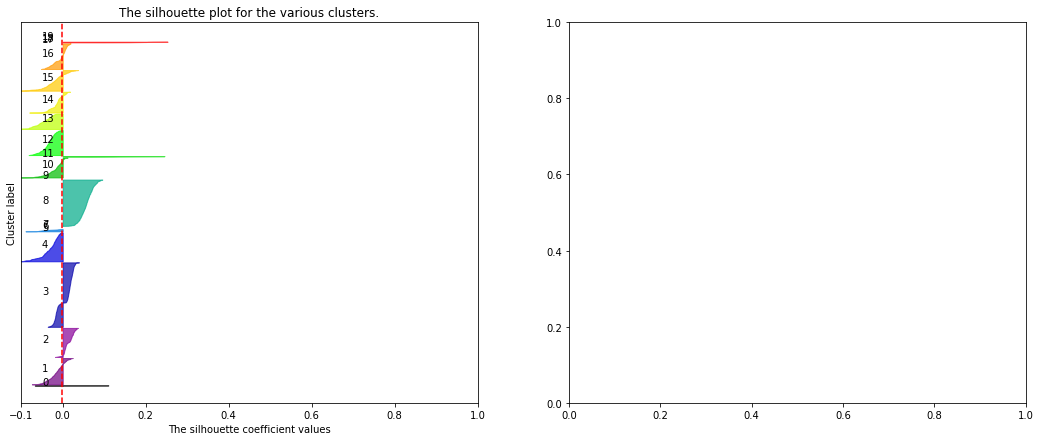

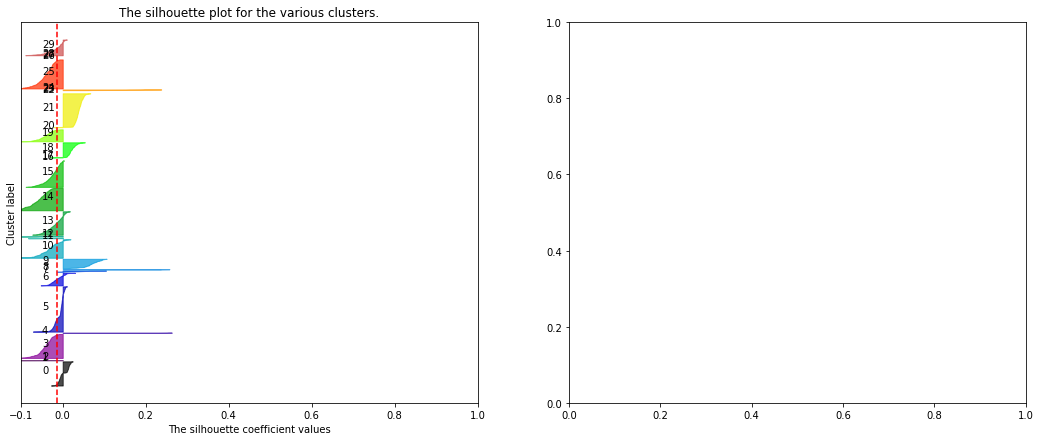

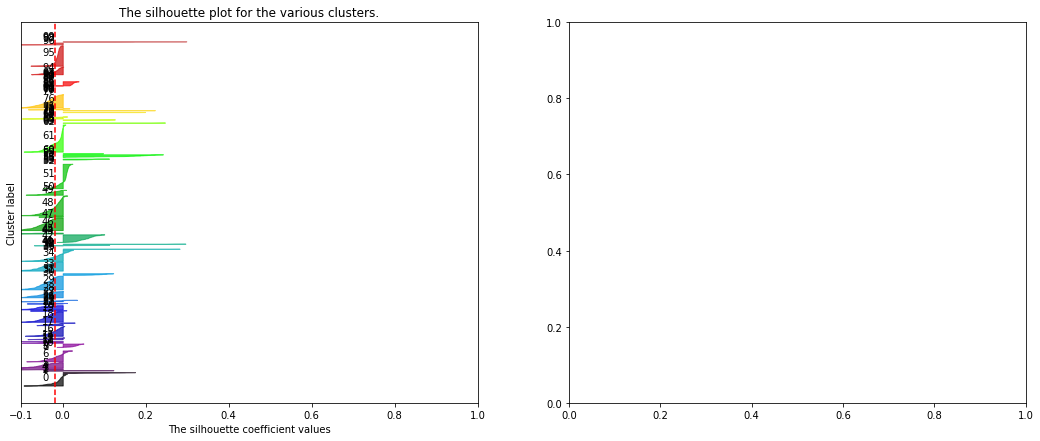

In [18]:
# removed credits with actors
tmdb_cluster = join_dataframes(df_genre,df_prod_cos,df_prod_country,df_keyword)
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,10,20,30,100]
silhouette_scores(tmdb_cluster, range_n_clusters, KMeans)

For n_clusters = 2 The average silhouette_score is : 0.03588184018085676
For n_clusters = 3 The average silhouette_score is : 0.023160714308103642
For n_clusters = 4 The average silhouette_score is : 0.021300200284325475
For n_clusters = 5 The average silhouette_score is : 0.04627570584575987
For n_clusters = 10 The average silhouette_score is : 0.018956449691990528
For n_clusters = 20 The average silhouette_score is : 0.001370951797085589
For n_clusters = 30 The average silhouette_score is : -0.007013278772219387
For n_clusters = 100 The average silhouette_score is : -0.005524537802614737


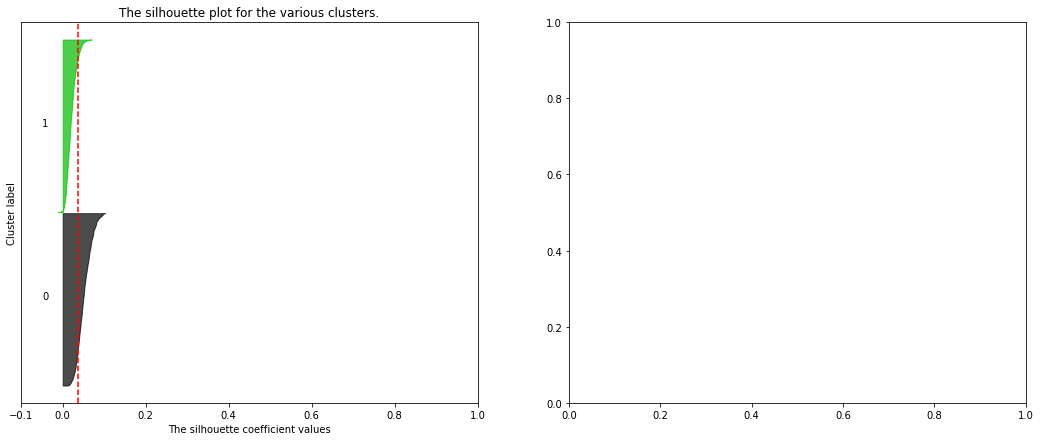

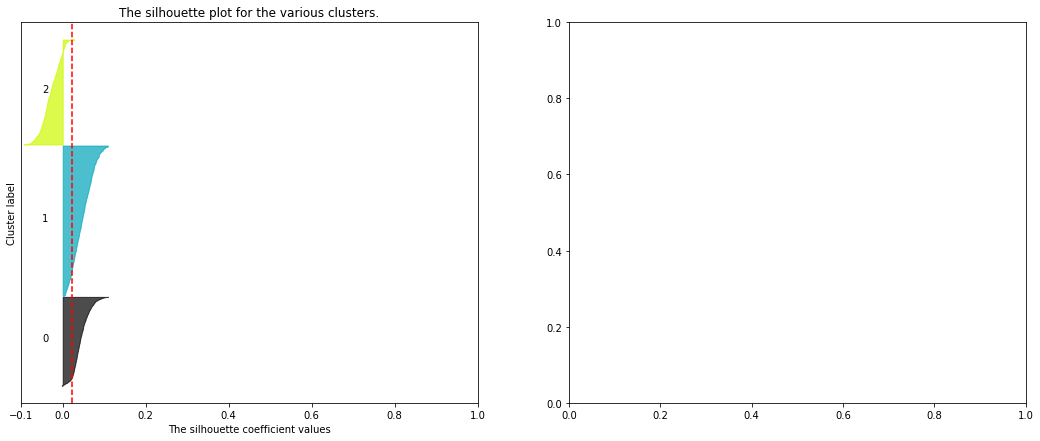

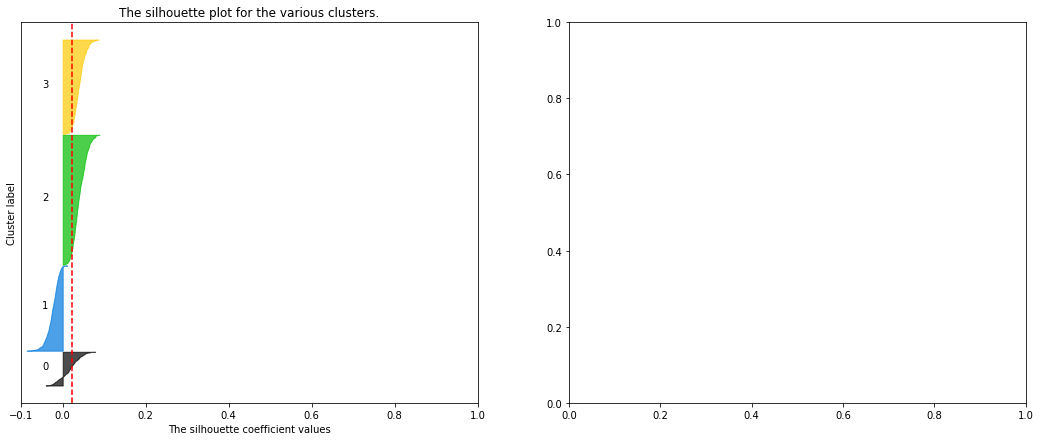

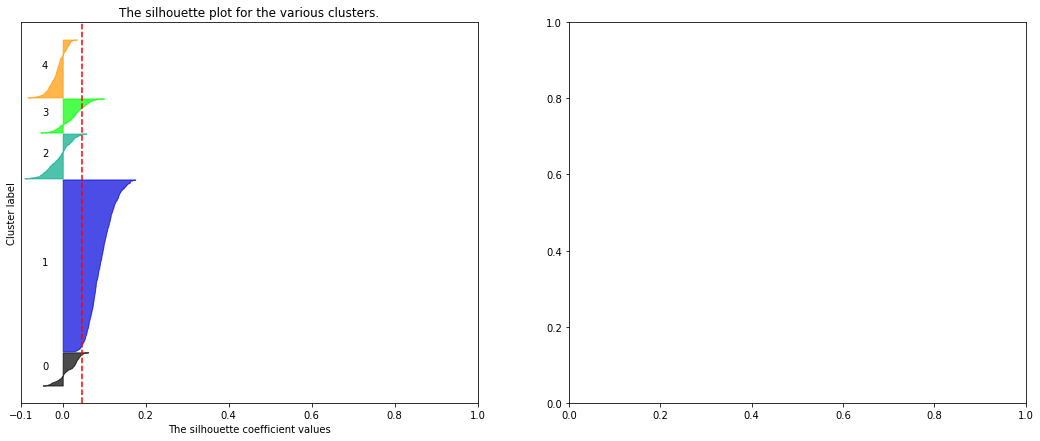

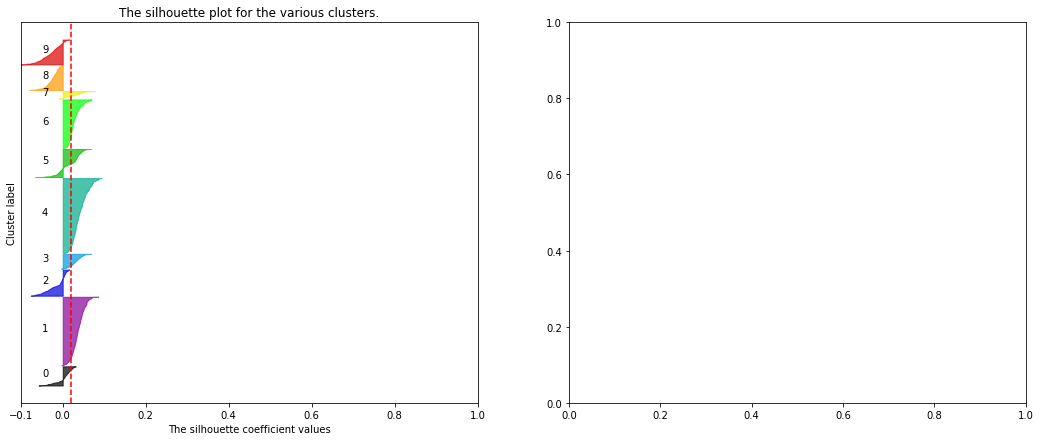

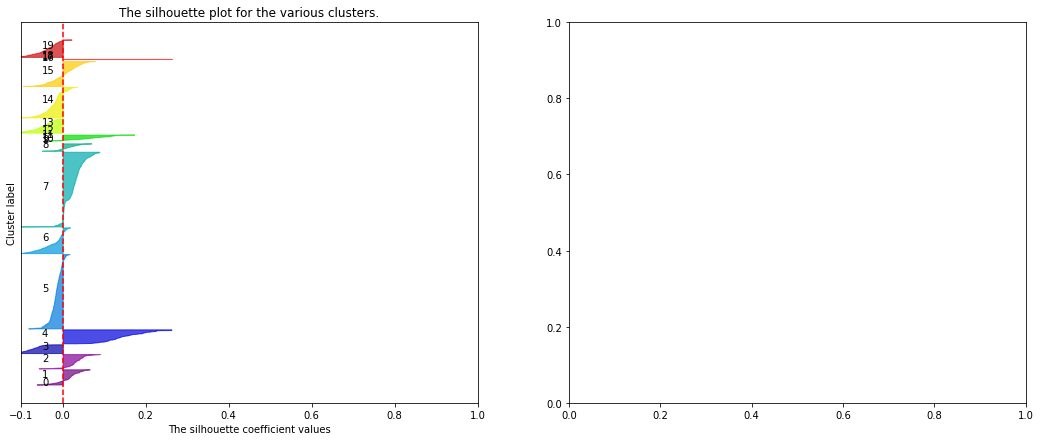

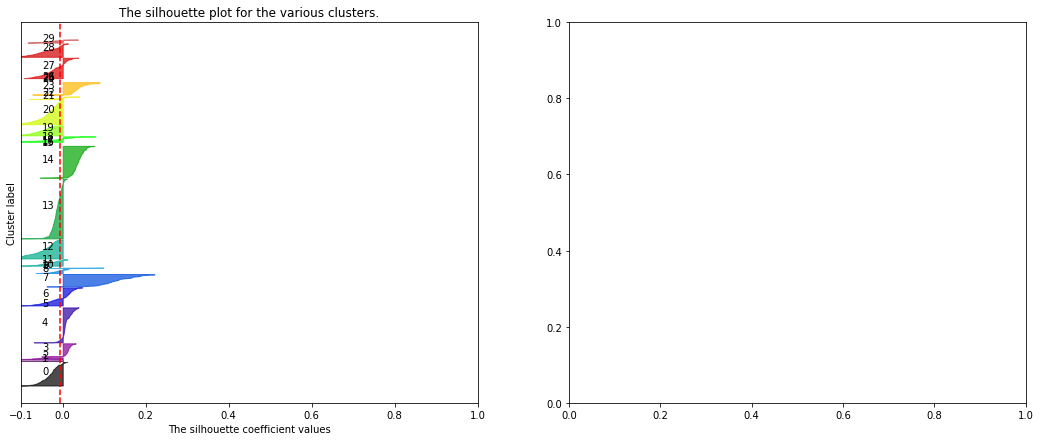

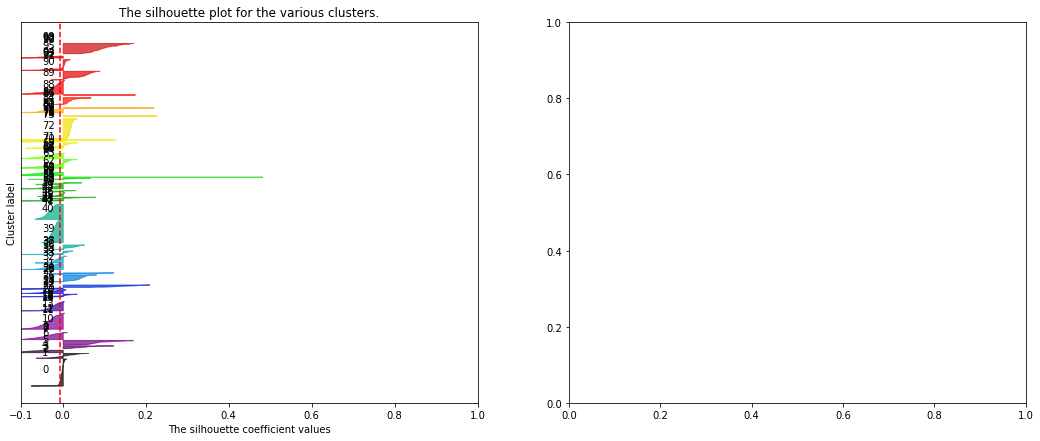

In [19]:
# only looking 
tmdb_cluster = join_dataframes(df_genre,df_keyword)
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,10,20,30,100]
silhouette_scores(tmdb_cluster, range_n_clusters, KMeans)

Better silhouette scores after removing the actor credits, but still not good enough scores to be useful or represent structure within the data. However, removing the actor credits did speed up the clustering process as it removes a ton of dimensions. I will remove actor credits from further analysis and modeling as it doesn't seem to a be a useful indicator. The next iteration of the model I will perhaps only bring the top 3 actor credits instead of top 10.

Same issue when just looking at genres and keywords. I'm surprised by this finding, I expected to find some level of similarity across titles when looking at genre and keywords.

### Clustering on tf_idf of movie keywords and genres

In [20]:
from themoviedb import cluster_movie_keywords

df_keyword_cluster, model, X_tfidf = cluster_movie_keywords(df_keyword_stage,10)

For n_clusters = 2 The average silhouette_score is : 0.011560820374988153
For n_clusters = 3 The average silhouette_score is : 0.01344115099776048
For n_clusters = 4 The average silhouette_score is : 0.019352973932857263
For n_clusters = 5 The average silhouette_score is : 0.019336784047526707
For n_clusters = 10 The average silhouette_score is : 0.025075700134448226
For n_clusters = 20 The average silhouette_score is : 0.030116749592079026
For n_clusters = 30 The average silhouette_score is : 0.032827988234830074
For n_clusters = 40 The average silhouette_score is : 0.03391376072593723
For n_clusters = 60 The average silhouette_score is : 0.03997947116931368
For n_clusters = 80 The average silhouette_score is : 0.042031077349209425
For n_clusters = 100 The average silhouette_score is : 0.007253141142798044


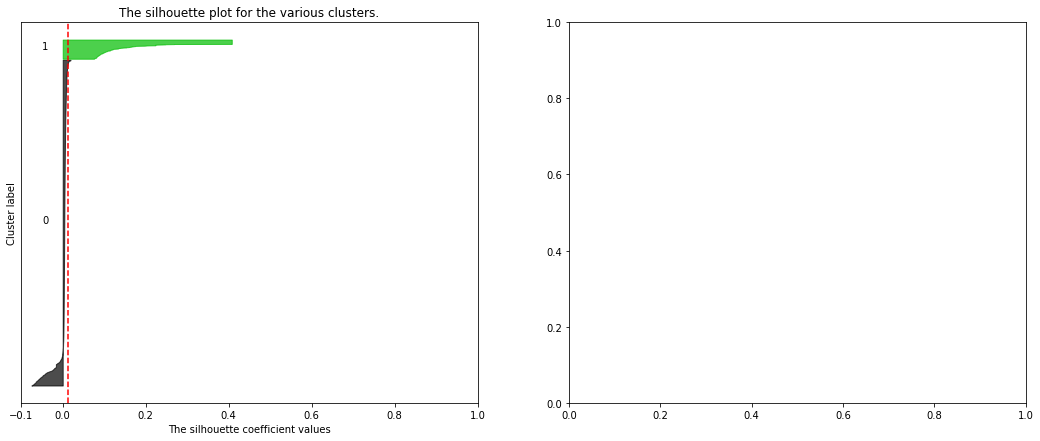

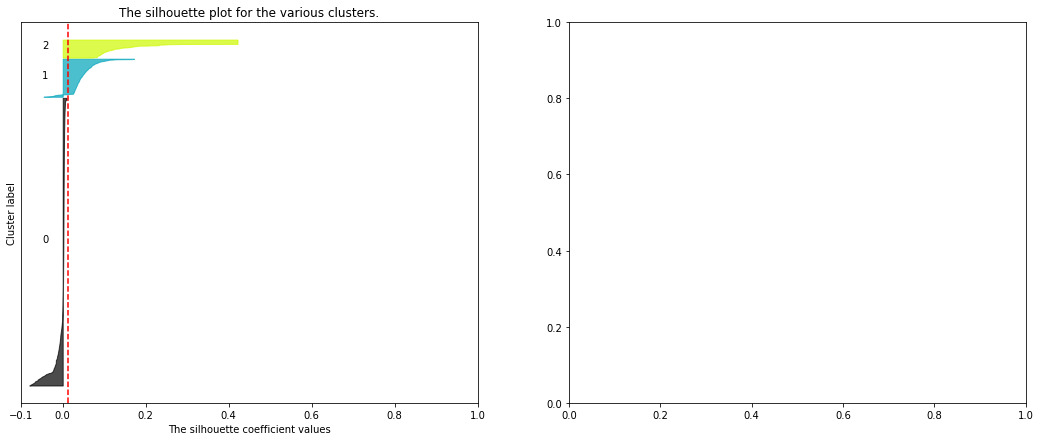

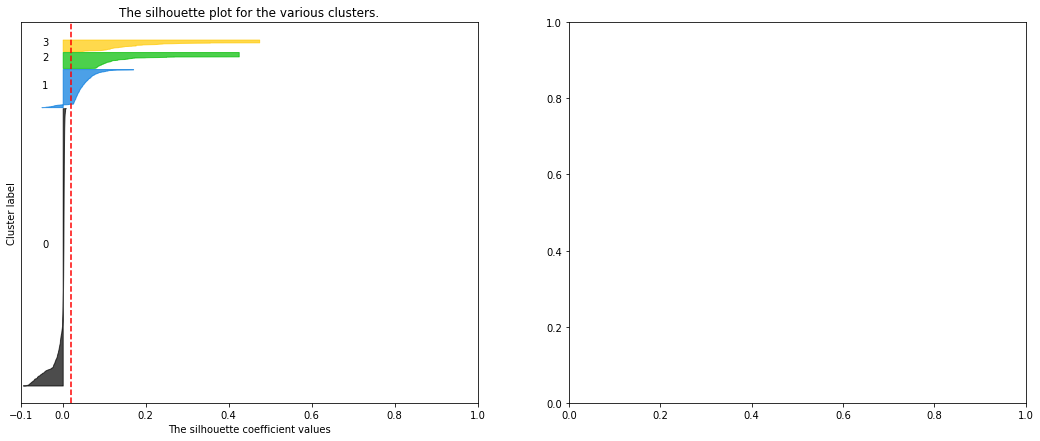

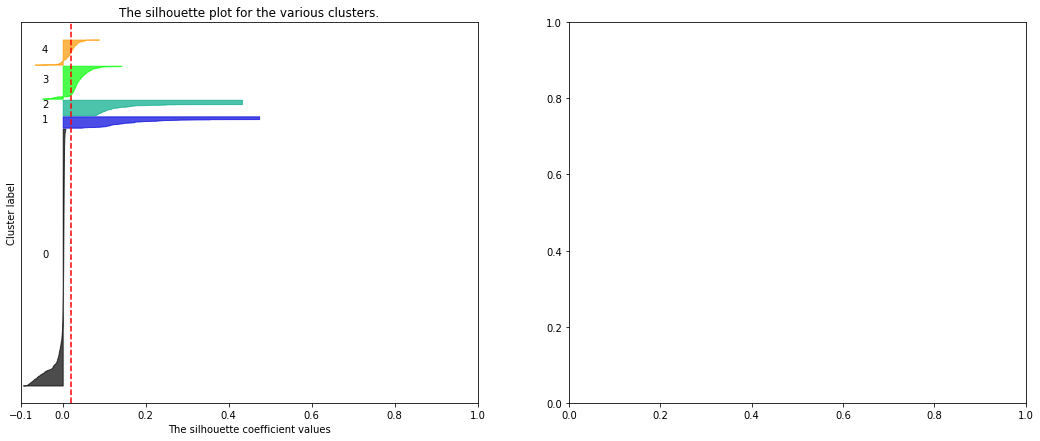

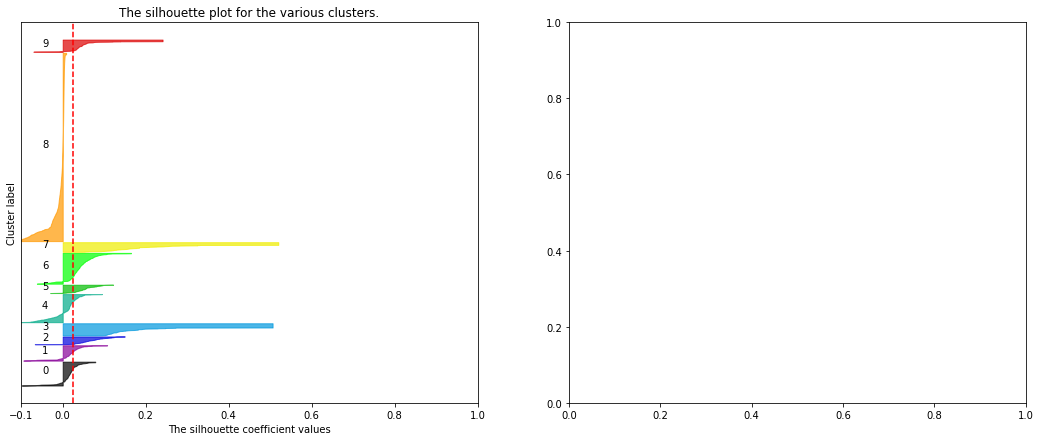

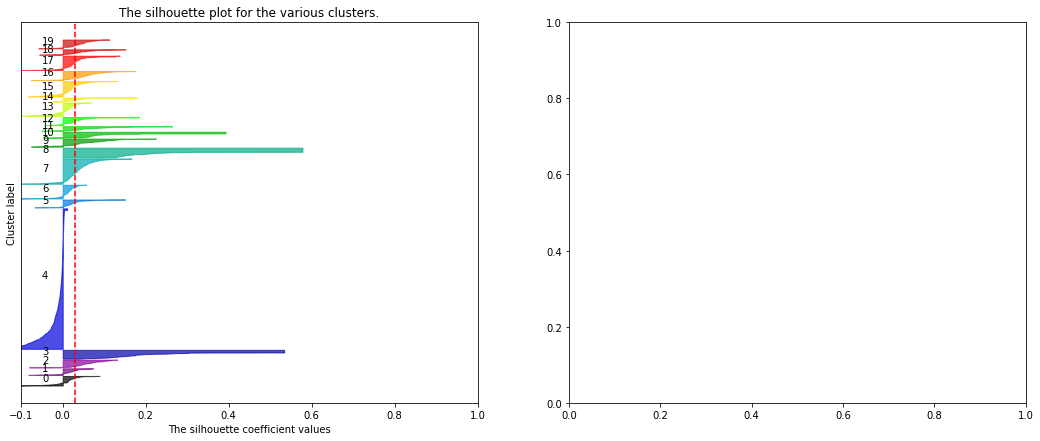

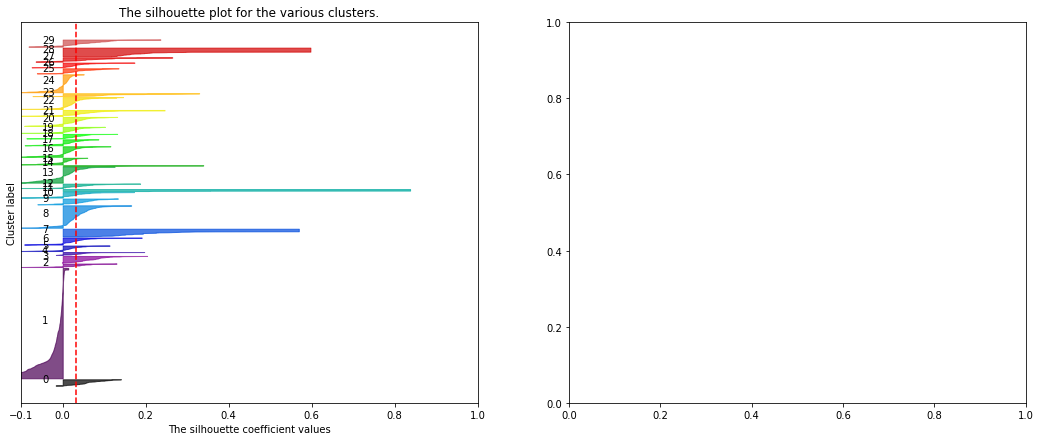

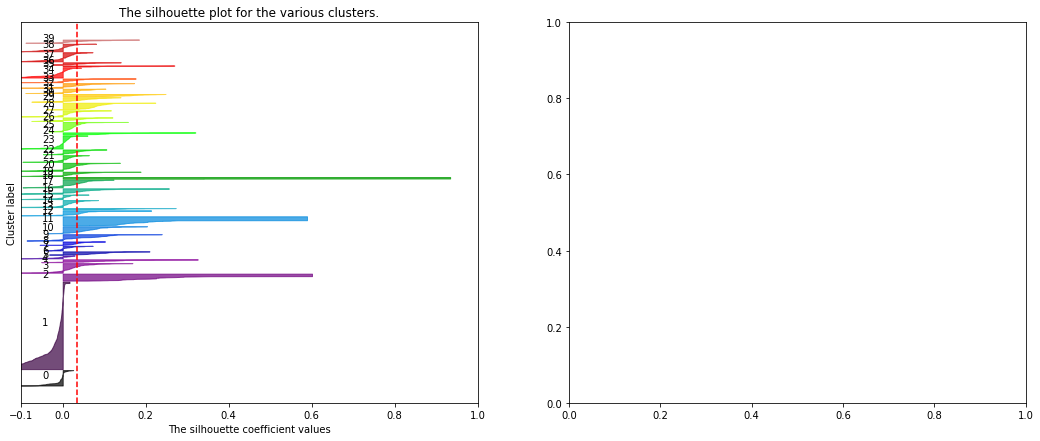

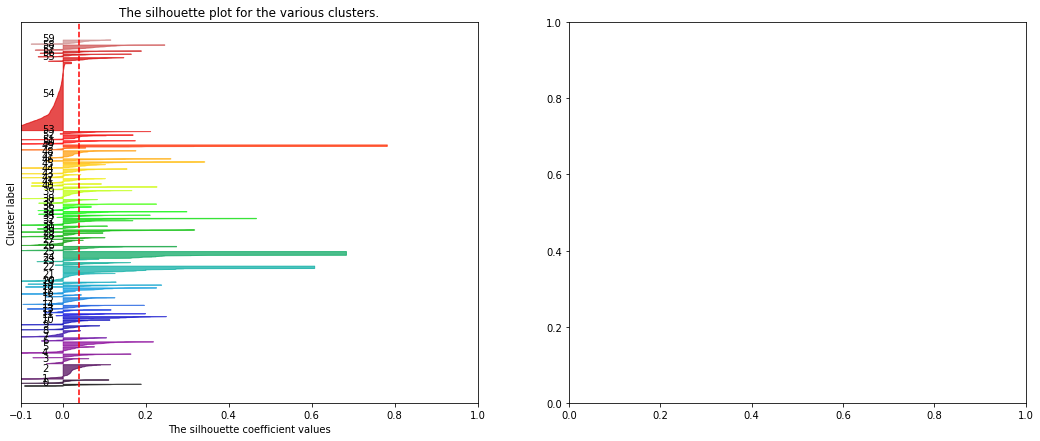

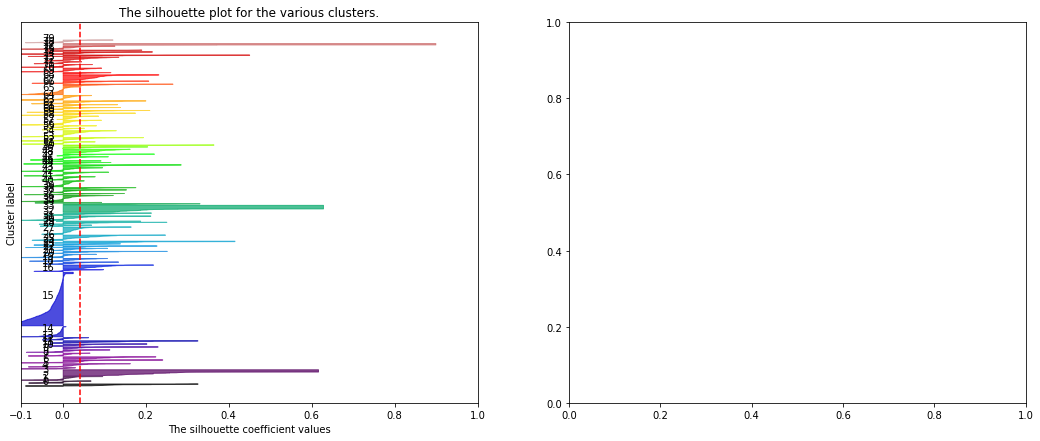

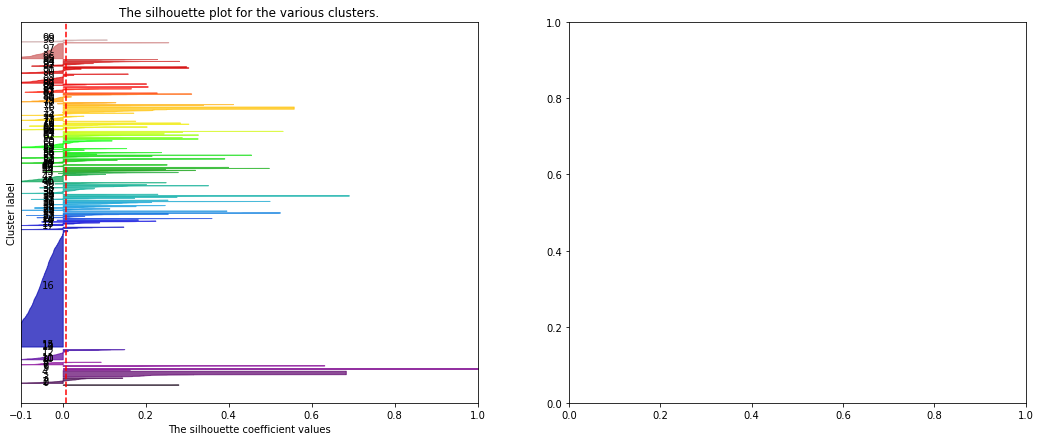

In [21]:
range_n_clusters = [2,3,4,5,10,20,30,40,60,80,100]
silhouette_scores(X_tfidf, range_n_clusters, KMeans)

The code is a little backwards here. However, the silhouette plots / scores determined the number of clusters I used in the keyword cluster. The main motivation here was to cut down on the number of dimensions in my model by clustering keywords after using a tf-idf vectorizer on the all the keywords for a movie. This produced slightly better results than clustering based on keywords alone. 

In [22]:
# merge all separate items back into main df_tmdb dataframe, removing actor credits after clustering findings
# also removing production COMPANIES, will capture this information from bomojo with dstributor
df_tmdb_final = join_dataframes(df_tmdb,df_video,df_genre,df_prod_country,df_keyword_cluster)
df_tmdb_final['keyword_cluster'] = df_tmdb_final['keyword_cluster'].apply(str)
df_tmdb_final = df_tmdb_final.drop(['credits','id','imdb_id','genres','keywords','keyword','overview','revenue',
                                    'video_stats','production_companies','production_countries','tagline','title'],axis=1)

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


### Clustering box office mojo information

In [23]:
# filling in any gaps for release dates
df_release = df_bomojo[['release_date']].join(df_tmdb[['release_date']],lsuffix='_x',rsuffix='_y')
df_release['release_date'] = df_release['release_date_x'].fillna(df_release['release_date_y'])
df_bomojo = df_bomojo.join(df_release[['release_date']],rsuffix='_clean')

df_bomojo = df_bomojo.drop('ww_box_office',axis=1).dropna()
df_bomojo['week_number'] = df_bomojo.release_date_clean.dt.week
df_bomojo['week_number'] = pd.Categorical(df_bomojo.week_number)

In [24]:
x = df_bomojo.num_theaters
df_bomojo['scaled_num_theaters'] = (x - x.min())/(x.max() - x.min())
bomojo_cluster = df_bomojo[['genre', 'rating','distributor','week_number', 'scaled_num_theaters']]
bomojo_cluster = pd.get_dummies(bomojo_cluster)

For n_clusters = 2 The average silhouette_score is : 0.09659000149325278
For n_clusters = 3 The average silhouette_score is : 0.12512259637469592
For n_clusters = 4 The average silhouette_score is : 0.13255359962712093
For n_clusters = 5 The average silhouette_score is : 0.08916755404502466
For n_clusters = 6 The average silhouette_score is : 0.05837054649800027
For n_clusters = 7 The average silhouette_score is : 0.06541777931225153
For n_clusters = 8 The average silhouette_score is : 0.0701796156672103
For n_clusters = 9 The average silhouette_score is : 0.07333259662820484
For n_clusters = 10 The average silhouette_score is : 0.06530374785905062
For n_clusters = 20 The average silhouette_score is : 0.0959381412553019
For n_clusters = 30 The average silhouette_score is : 0.09586332213294783
For n_clusters = 100 The average silhouette_score is : 0.08004651469191405


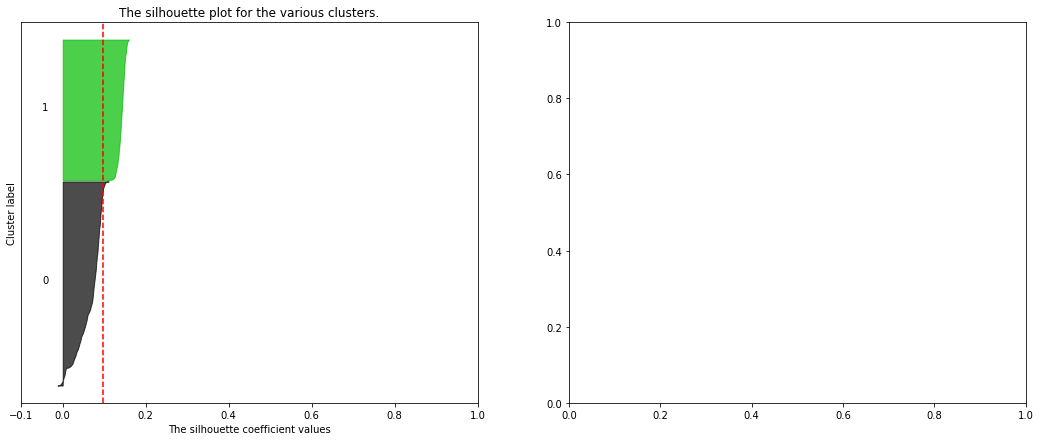

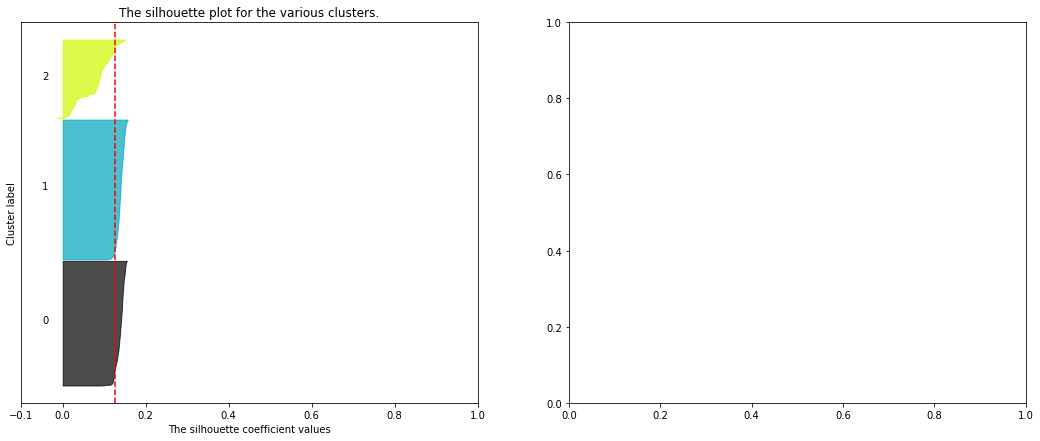

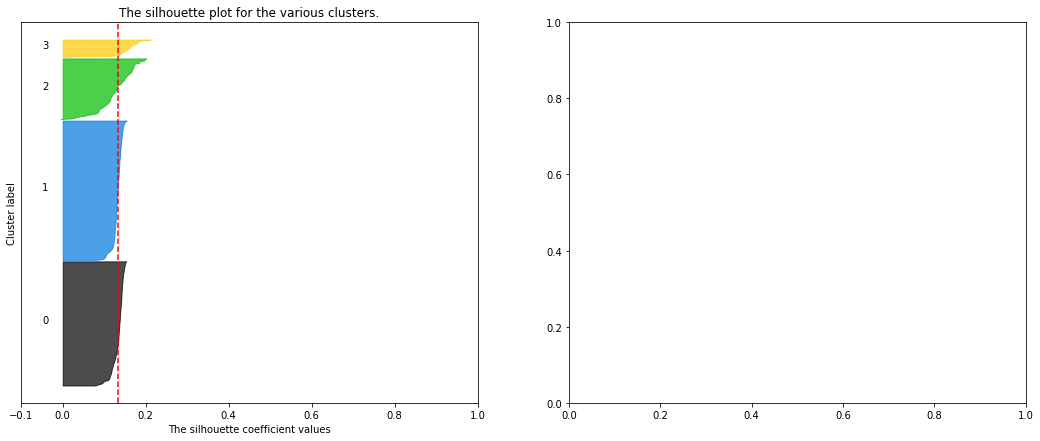

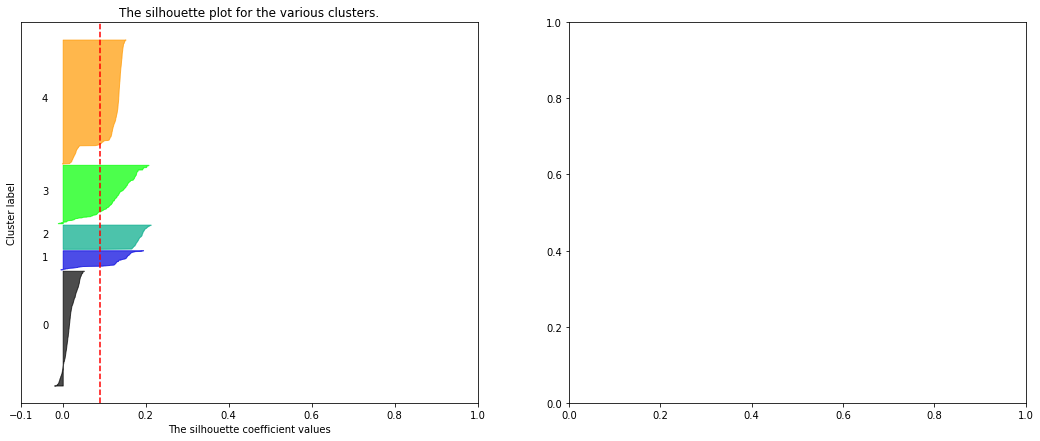

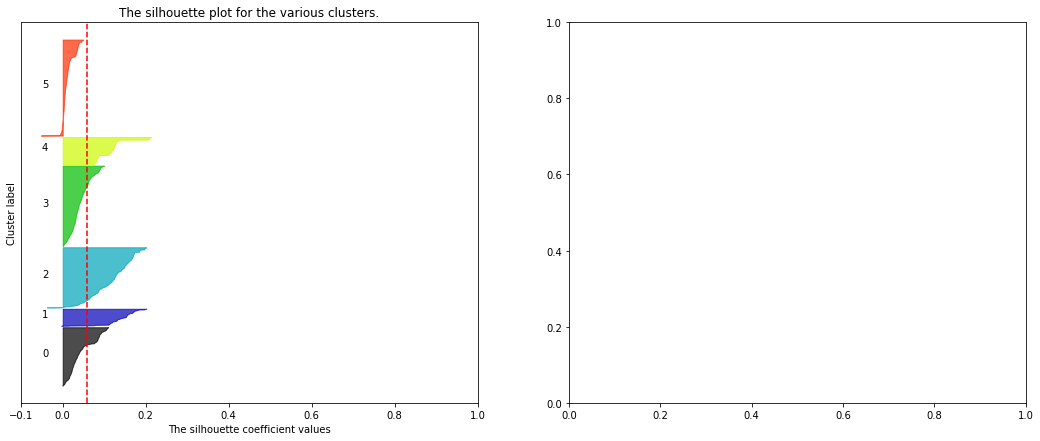

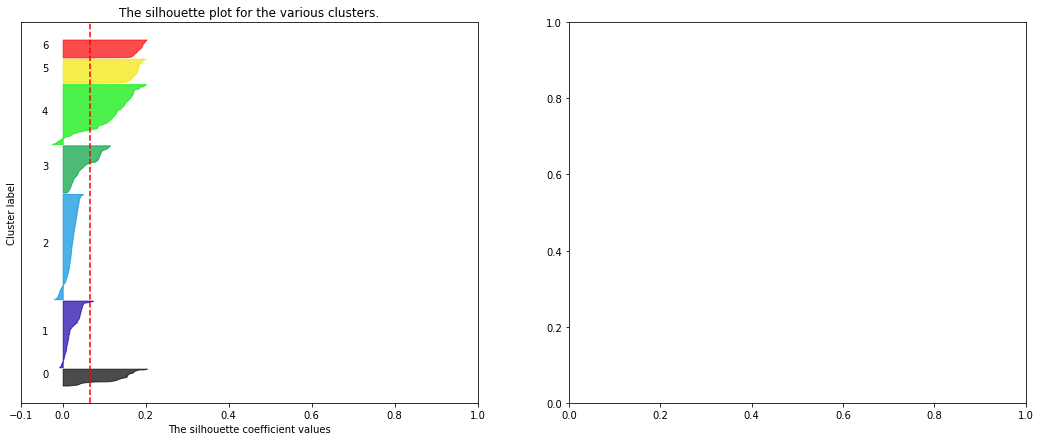

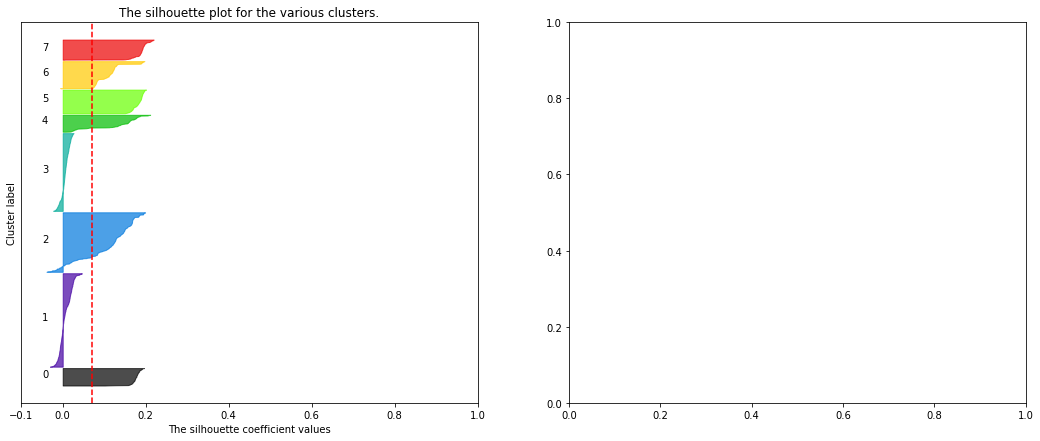

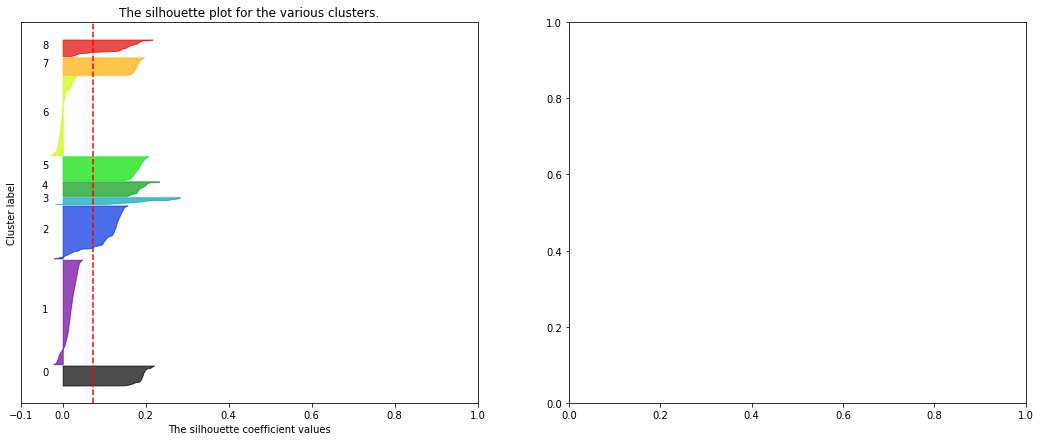

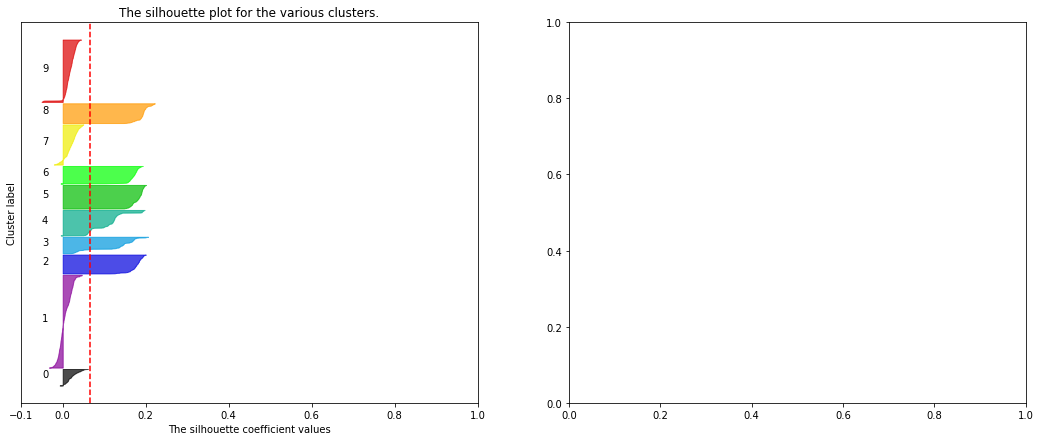

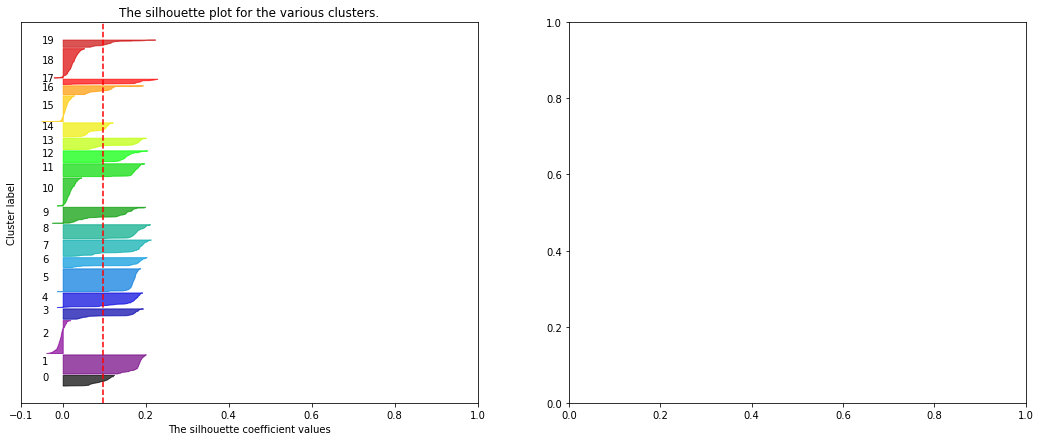

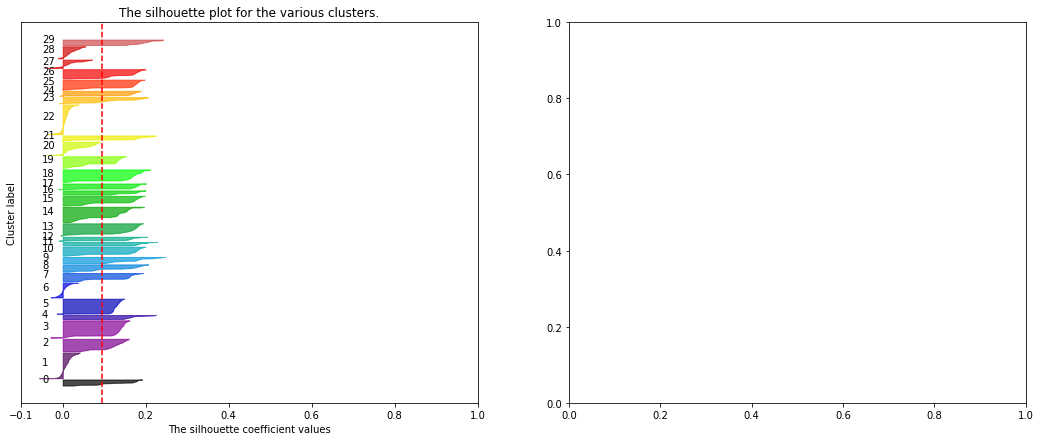

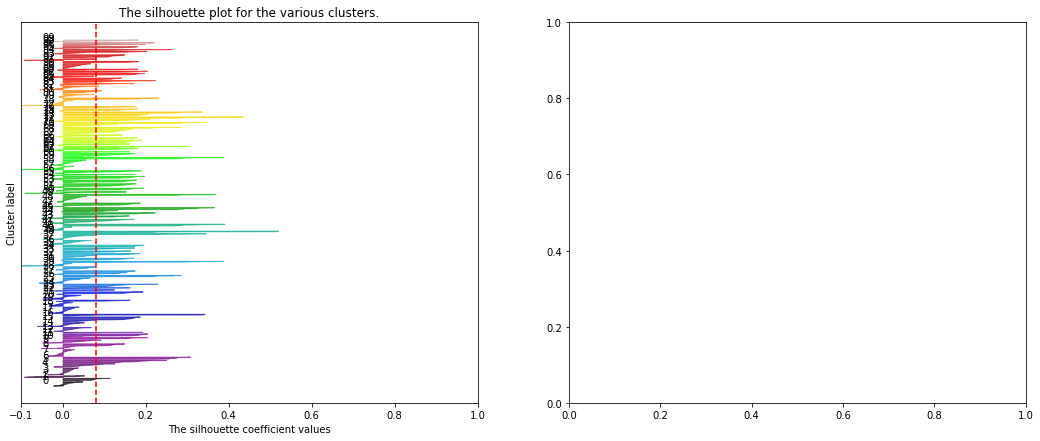

In [25]:
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,6,7,8,9,10,20,30,100]
silhouette_scores(bomojo_cluster, range_n_clusters, KMeans)

Chose to go with 4 clusters because that definitely had the highest silhouette score and most distributed silhouette plot. I was getting much different results prior to scaling the number of theaters, which makes sense. The silhouette scores are much worse, because before the unscaled theater values were driving the relationship in the data. 

In [26]:
def scatter_graph(data, x, y, hue):
    plt.figure(figsize=(16,8))
    sns.scatterplot(x=x,y=y,hue=hue,data=data)
    plt.show()

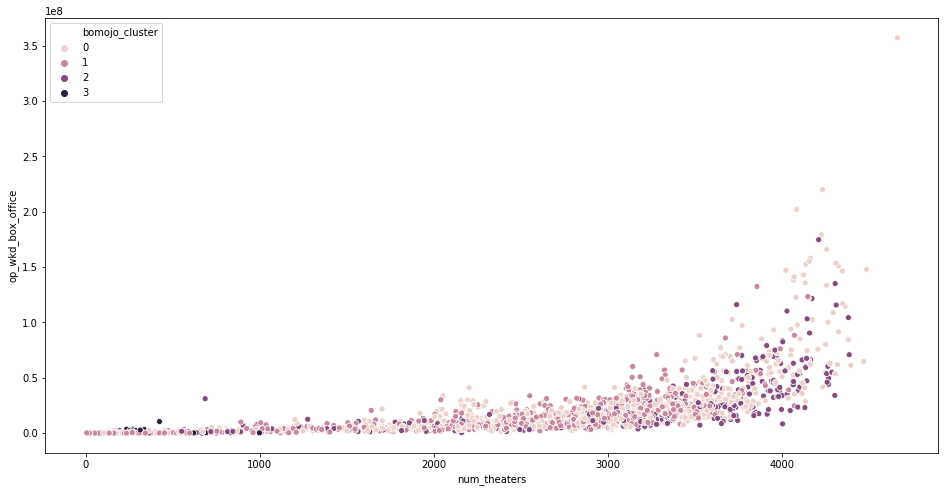

In [27]:
df_bomojo['bomojo_cluster'] =  KMeans(n_clusters=4, random_state=42).fit_predict(bomojo_cluster)
scatter_graph(df_bomojo,'num_theaters','op_wkd_box_office','bomojo_cluster')

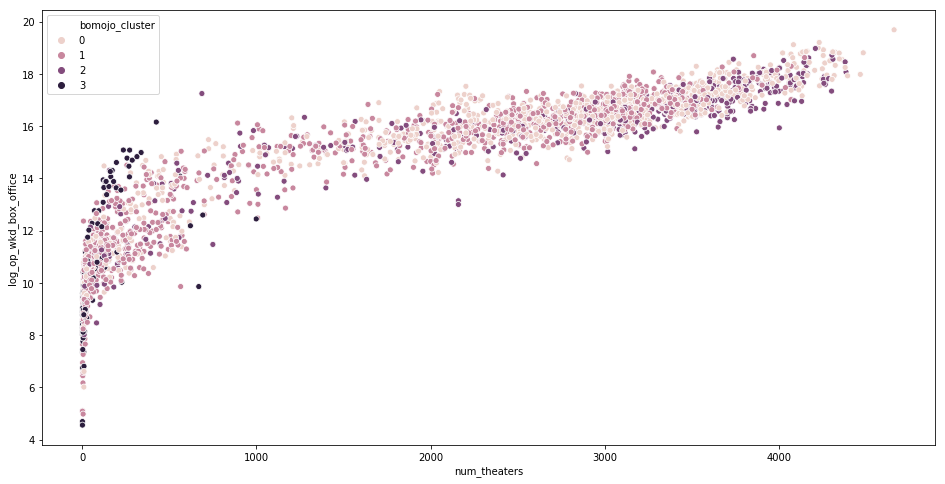

In [28]:
df_bomojo['log_op_wkd_box_office'] = np.log(df_bomojo['op_wkd_box_office'])
scatter_graph(df_bomojo,'num_theaters','log_op_wkd_box_office','bomojo_cluster')                                       

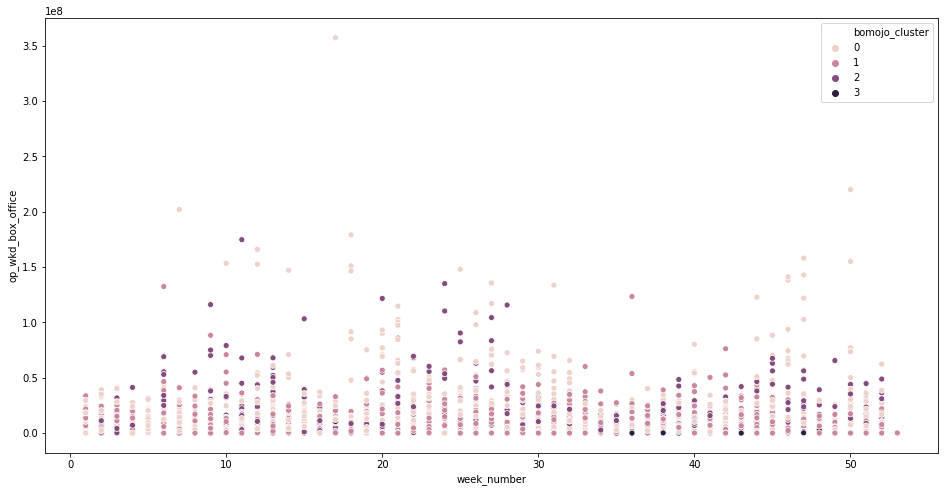

In [29]:
scatter_graph(df_bomojo,'week_number','op_wkd_box_office','bomojo_cluster')

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


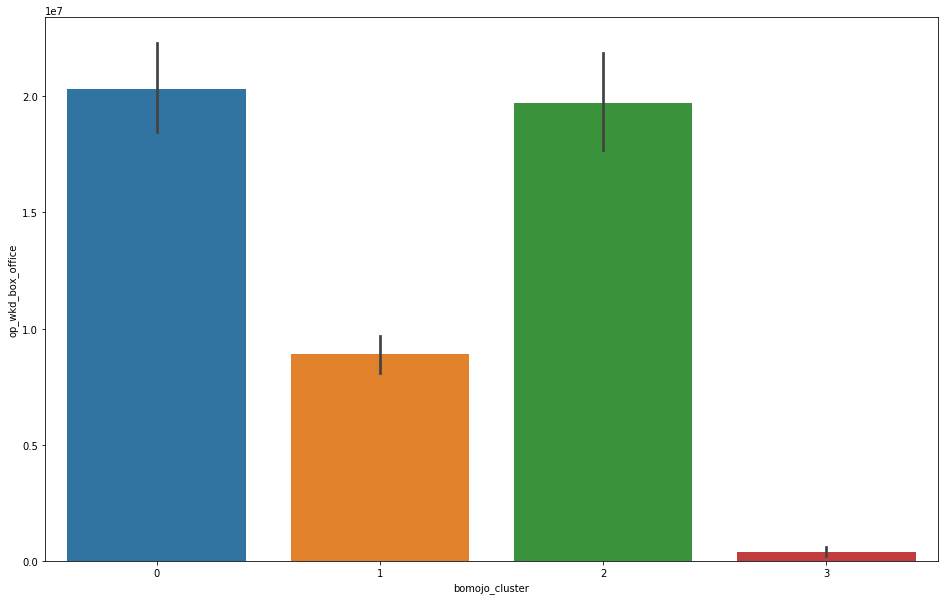

In [30]:
plt.figure(figsize=(16,10))
sns.barplot(x='bomojo_cluster',y='op_wkd_box_office',data=df_bomojo)
plt.show()

### Create wikipedia pageview features

In [31]:
from wikipedia import clean_pageviews

pageviews = []
for url, title in zip(df_wiki.index, df_wiki.clean_wiki_url):
    pageviews.append(clean_pageviews(df_wiki_pageviews, df_release, url, title))

df_pageviews = pd.DataFrame(pageviews).set_index('wiki_url')

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Finally, join all dataframe together on wiki_url index. Will drop the columns I don't need before modeling purposes. I would like to run two models for this analysis depending on if that's possible: 

1) WITH pageview features. This limits the number of films to only ~3-4 years worth, but I have more features

2) WITHOUT pageview features. This increases the number of films to 10+ years, but reduces the number of overall features

In [32]:
def join_dataframes_outer(df1, *others):
    new_df = df1
    for df in others:
        new_df = new_df.merge(df,left_index=True, right_index=True,how='outer') 
    return new_df

In [33]:
df_bo_predictor = join_dataframes_outer(df_tmdb_final,df_rt, df_mc, df_bomojo)
df_bo_predictor.to_csv('data/df_bo_predictor.csv',sep=',',index=True)

In [34]:
df_bo_predictor_wpv = join_dataframes_outer(df_tmdb_final,df_rt, df_mc, df_bomojo,df_pageviews)
# df_bo_predictor_wpv.to_csv('data/df_bo_predictor_wpv.csv',sep=',',index=True)

In [35]:
for df in [df_tmdb_final,df_rt, df_mc, df_bomojo,df_pageviews]:
    print(df.shape)

(3035, 141)
(3545, 5)
(2994, 2)
(2593, 14)
(1343, 25)


At the moment, unable to figure out why the wiki_pageview data is not matching up to the other tables. I will have to remove the wikipedia pageview data entirely from the analysis.

In [36]:
# at some point, look to either scaling pageview data or using PCA for pageview data
# and run model with that versus clustering

### Final dataframe and visualizations
(Can bypass above if you have already saved final dataframe, read csv below)

In [37]:
df_bo_predictor = pd.read_csv('data/df_bo_predictor.csv', index_col='wiki_url')
# df_bo_predictor_wpv = pd.read_csv('data/df_bo_predictor_wpv.csv', index_col='wiki_url')

In [38]:
# create additional metric to predict: film multiple which is the total film performance divided by
# its opening weekend performance
df_bo_predictor['film_multiple'] = df_bo_predictor.dom_box_office / df_bo_predictor.op_wkd_box_office
# df_bo_predictor_wpv['film_multiple'] = df_bo_predictor_wpv.dom_box_office / df_bo_predictor_wpv.op_wkd_box_office

In [39]:
df_bo_predictor.head()

,budget,popularity,release_date_x,runtime,vote_average,vote_count,"('viewCount', 'count')","('viewCount', 'min')","('viewCount', 'max')","('viewCount', 'mean')",...,op_wkd_box_office,rating,release_date_y,title,release_date_clean,week_number,scaled_num_theaters,bomojo_cluster,log_op_wkd_box_office,film_multiple
wiki_url,,,,,,,,,,,,,,,,,,,,,
/wiki/$9.99,0.0,3.191,2008-09-04,78.0,6.2,47.0,0.000000,0.000032,0.000001,0.000004,...,478.0,R,2008-12-12,$9.99,2008-12-12,50.0,0.000644,1.0,6.169611,109.589958
/wiki/%2771_(film),11000000.0,8.884,2014-10-10,99.0,6.8,623.0,0.029412,0.000008,0.000537,0.001228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/wiki/%C3%86on_Flux_(film),62000000.0,13.100,2005-11-30,93.0,5.5,1095.0,0.000000,0.015287,0.000562,0.002103,...,12661112.0,PG-13,2005-12-02,Aeon Flux,2005-12-02,48.0,0.559322,0.0,16.354046,2.043607
/wiki/(500)_Days_of_Summer,7500000.0,14.378,2009-07-17,95.0,7.2,5551.0,0.029412,0.001915,0.000337,0.000908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/wiki/(Untitled)_(2009_film),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_bo_predictor.describe()

,budget,popularity,runtime,vote_average,vote_count,"('viewCount', 'count')","('viewCount', 'min')","('viewCount', 'max')","('viewCount', 'mean')","('viewCount', 'median')",...,critic_score,score,dom_box_office,num_theaters,op_wkd_box_office,week_number,scaled_num_theaters,bomojo_cluster,log_op_wkd_box_office,film_multiple
count,3.035000e+03,3035.000000,3010.000000,3035.000000,3035.000000,3035.000000,3035.000000,3035.000000,3035.000000,3035.000000,...,3545.000000,2562.000000,2.593000e+03,2593.000000,2.593000e+03,2593.000000,2593.000000,2593.000000,2593.000000,2593.000000
mean,3.462414e+07,11.554383,107.323588,6.249621,1557.286656,0.014507,0.030055,0.003072,0.006675,0.022654,...,52.683780,55.166667,4.556431e+07,1982.741226,1.453943e+07,26.431546,0.425175,0.917084,14.726096,7.439581
std,5.002073e+07,15.087926,18.070785,1.075494,2460.790426,0.036892,0.069147,0.019105,0.021922,0.048565,...,28.935724,17.886032,7.108868e+07,1397.677566,2.279220e+07,14.780598,0.299866,0.860029,2.788751,16.317860
min,0.000000e+00,0.600000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,9.500000e+01,1.000000,9.500000e+01,1.000000,0.000000,0.000000,4.553877,1.000000
25%,0.000000e+00,6.422000,95.000000,5.800000,170.000000,0.000000,0.000769,0.000128,0.000396,0.001144,...,28.000000,42.000000,2.552478e+06,311.000000,2.373930e+05,14.000000,0.066509,0.000000,12.377472,2.339492
50%,1.500000e+07,8.815000,104.000000,6.300000,609.000000,0.000000,0.005217,0.000649,0.001880,0.005731,...,54.000000,55.000000,2.070645e+07,2417.000000,7.736452e+06,27.000000,0.518344,1.000000,15.861454,2.944662
75%,4.300000e+07,12.949500,117.000000,6.900000,1812.500000,0.014706,0.027381,0.002746,0.007182,0.024178,...,79.000000,68.000000,5.780695e+07,3127.000000,1.866786e+07,39.000000,0.670672,1.000000,16.742314,4.284119
max,5.000000e+08,473.246000,338.000000,8.600000,22016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,100.000000,100.000000,9.366622e+08,4662.000000,3.571150e+08,53.000000,1.000000,3.000000,19.693568,311.364861


In [41]:
df_bo_predictor_wpv.describe()

,budget,popularity,runtime,vote_average,vote_count,"(viewCount, count)","(viewCount, min)","(viewCount, max)","(viewCount, mean)","(viewCount, median)",...,median_total,median_week_2,median_week_3,median_week_4,std_month_2,std_month_3,std_total,std_week_2,std_week_3,std_week_4
count,3.065000e+03,3065.000000,3040.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,...,1336.000000,830.000000,815.000000,805.000000,798.000000,756.000000,1335.000000,829.000000,813.000000,804.000000
mean,3.434755e+07,11.529459,107.353947,6.253246,1548.107667,0.014509,0.030757,0.003082,0.006752,0.022985,...,1461.229790,7766.522892,6166.869939,4311.509938,1942.936341,1837.650578,4654.262688,1744.555771,1617.447685,1067.987390
std,4.985592e+07,15.017424,18.075171,1.072279,2450.719952,0.036752,0.075247,0.019042,0.022203,0.051000,...,1971.878359,11162.365888,8409.284345,6216.680790,4932.734303,3725.583861,10831.979167,3616.978840,3102.930221,2179.803841
min,0.000000e+00,0.600000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.113162,0.000000,5.932502,1.140175,0.500000,0.447214
25%,0.000000e+00,6.434000,95.000000,5.800000,171.000000,0.000000,0.000775,0.000124,0.000387,0.001130,...,322.000000,1223.750000,985.000000,846.000000,223.647374,152.177541,442.245939,179.551160,160.644387,127.684255
50%,1.500000e+07,8.815000,104.000000,6.300000,607.000000,0.000000,0.005072,0.000643,0.001862,0.005614,...,794.750000,4024.000000,3137.000000,2310.000000,654.265098,459.411973,1582.192913,669.366829,638.366778,383.250116
75%,4.200000e+07,12.875000,117.000000,6.900000,1790.000000,0.014706,0.027014,0.002715,0.007075,0.024039,...,1831.500000,9907.750000,7894.000000,5310.000000,1887.852899,1682.003048,4350.961668,1847.134783,1892.925765,1170.396857
max,5.000000e+08,473.246000,338.000000,8.600000,22016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,25556.000000,99863.000000,70730.000000,71191.000000,94790.936194,32605.131959,251133.215995,50322.902327,31181.424688,28051.790994


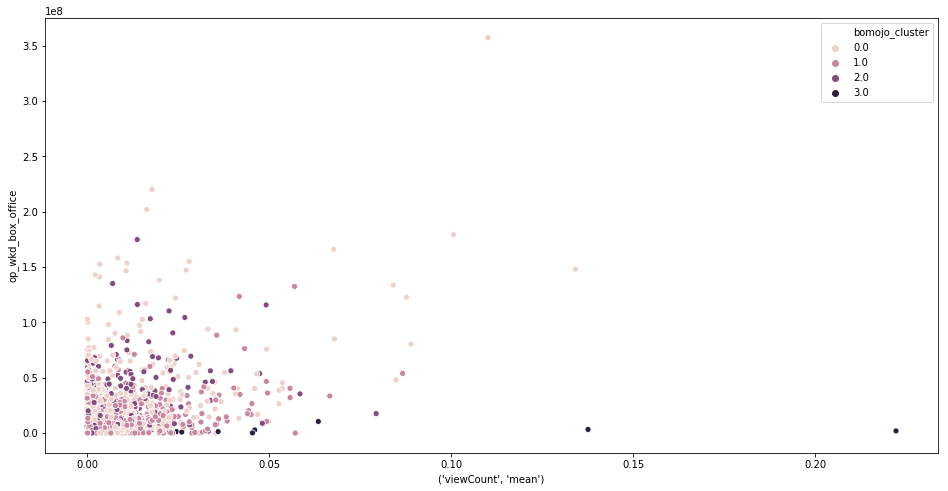

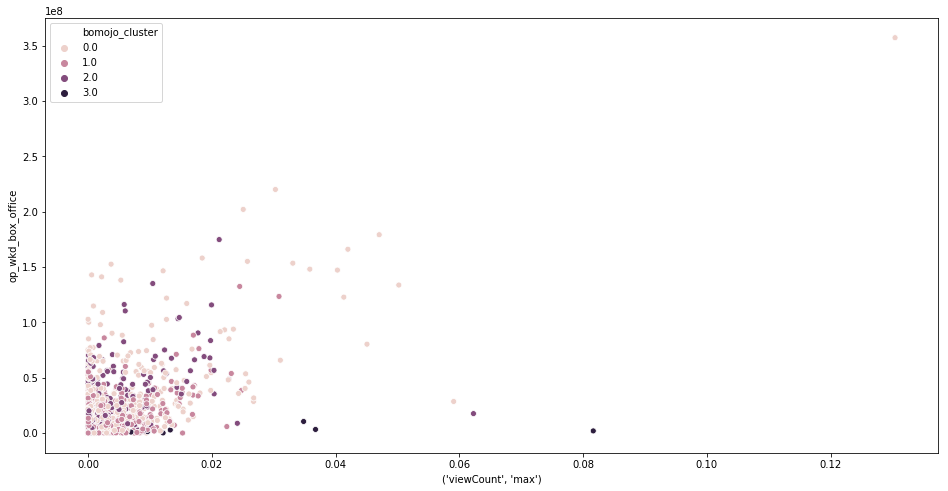

In [42]:
scatter_graph(df_bo_predictor,"('viewCount', 'mean')",'op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,"('viewCount', 'max')",'op_wkd_box_office','bomojo_cluster')

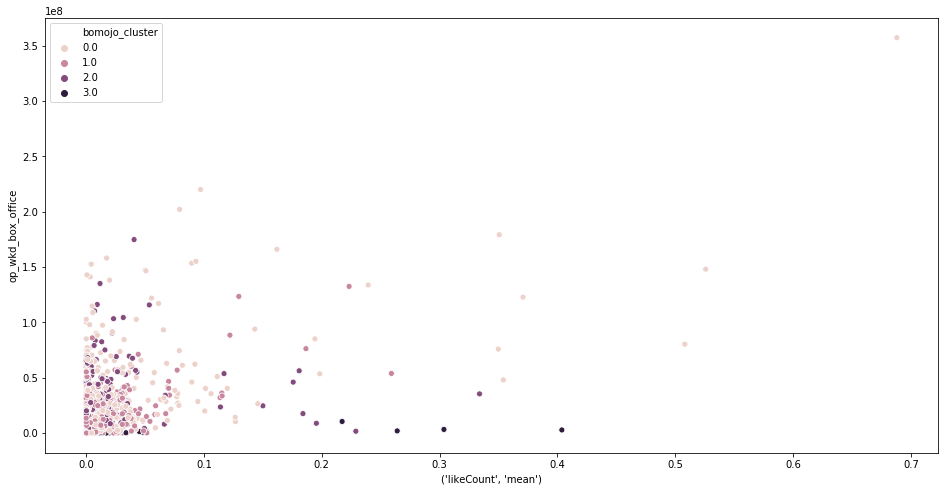

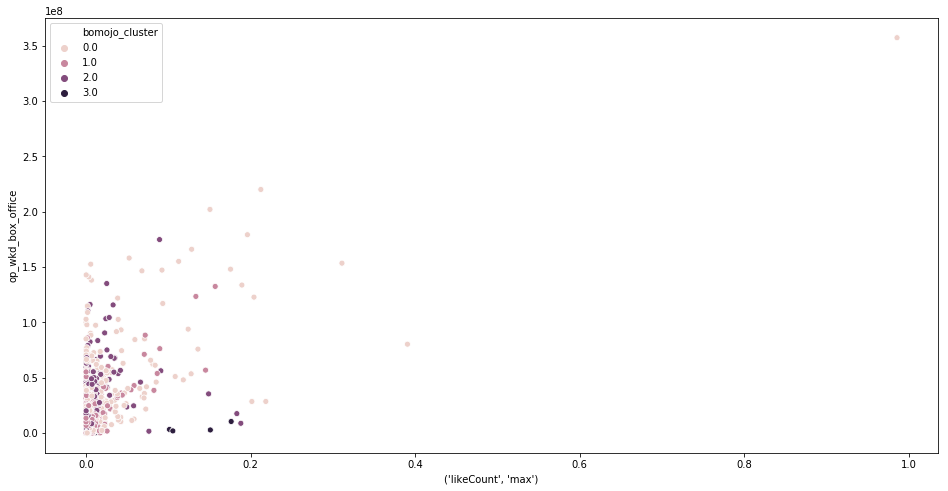

In [43]:
scatter_graph(df_bo_predictor,"('likeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,"('likeCount', 'max')",'op_wkd_box_office','bomojo_cluster')

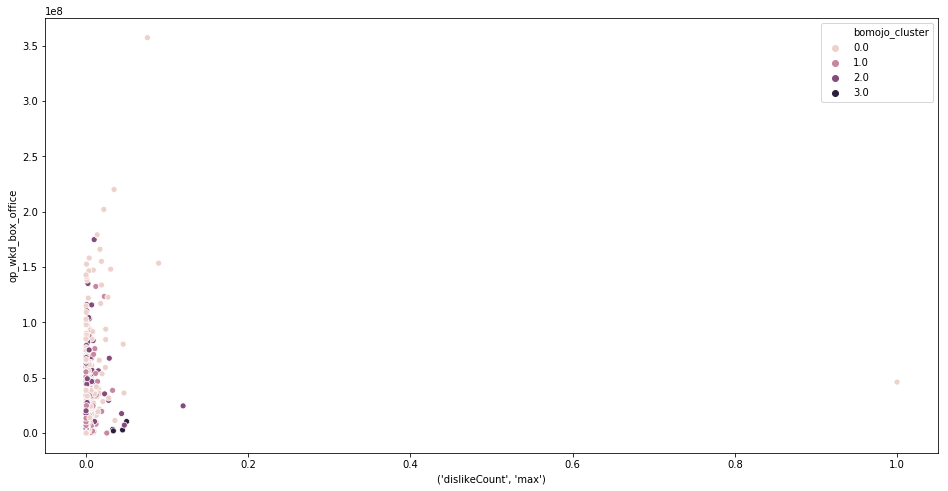

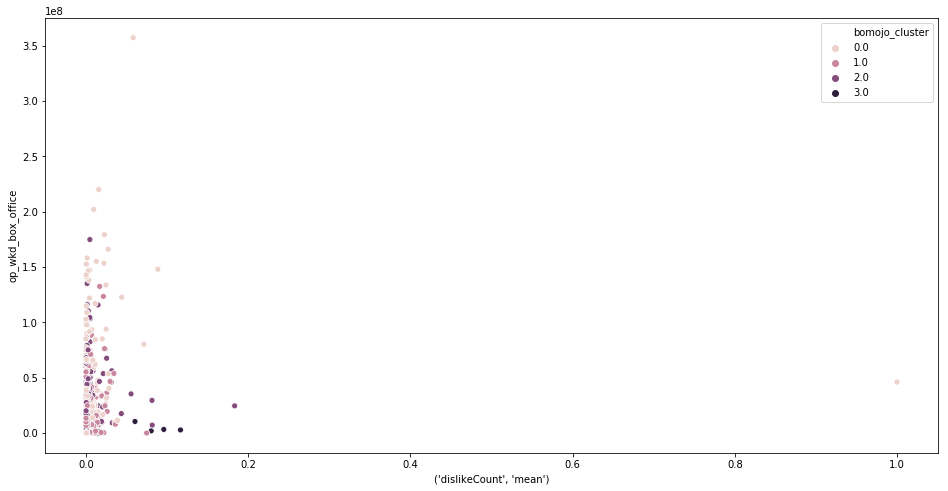

In [44]:
scatter_graph(df_bo_predictor,"('dislikeCount', 'max')",'op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,"('dislikeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')

In [45]:
df_bo_predictor[df_bo_predictor["('dislikeCount', 'mean')"] > .03]["('dislikeCount', 'max')"].sort_values(ascending=False)

wiki_url
/wiki/Ghostbusters_(2016_film)                      1.000000
/wiki/Frozen_(2013_film)                            0.669517
/wiki/The_Emoji_Movie                               0.119720
/wiki/Aladdin_(2019_film)                           0.097172
/wiki/Vedalam                                       0.081685
/wiki/Avengers:_Infinity_War                        0.075729
/wiki/Star_Wars:_The_Rise_of_Skywalker              0.066691
/wiki/Dora_and_the_Lost_City_of_Gold                0.066418
/wiki/Pok%C3%A9mon_Detective_Pikachu                0.061981
/wiki/Ocean%27s_8                                   0.057109
/wiki/Terminator:_Dark_Fate                         0.050372
/wiki/Baahubali_2:_The_Conclusion                   0.050116
/wiki/Diary_of_a_Wimpy_Kid:_The_Long_Haul_(film)    0.047270
/wiki/Venom_(2018_film)                             0.045845
/wiki/2.0_(film)                                    0.045126
/wiki/The_Smurfs_2                                  0.043871
/wiki/Joker_(20

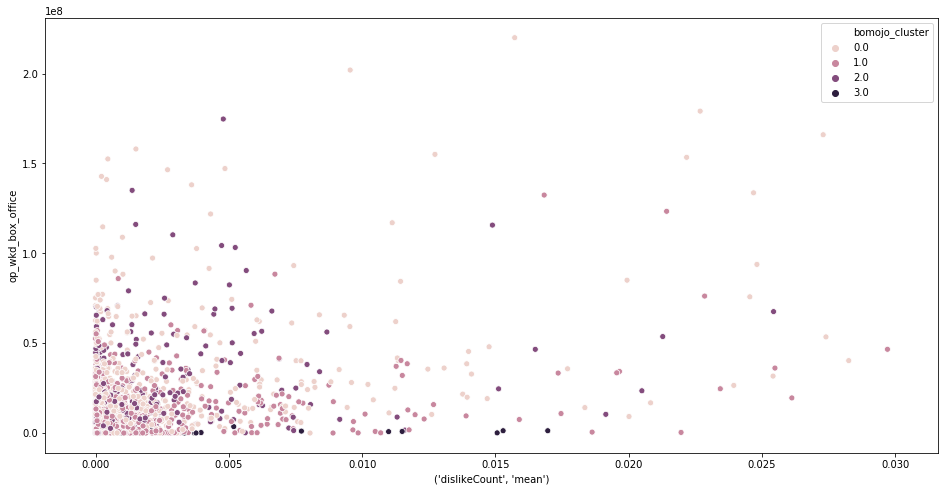

In [46]:
df_graph_test = df_bo_predictor[df_bo_predictor["('dislikeCount', 'mean')"] < .03]
scatter_graph(df_graph_test,"('dislikeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')

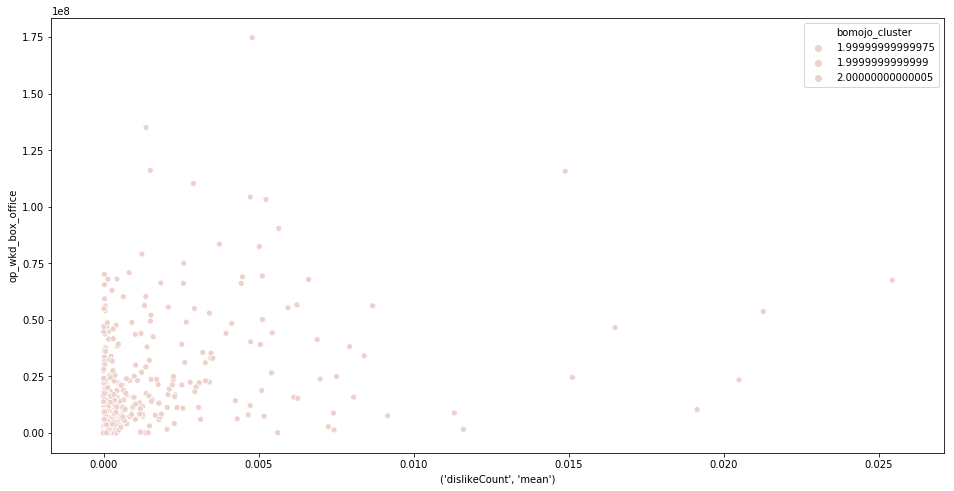

In [47]:
df_graph_test_2 = df_graph_test[df_graph_test['bomojo_cluster'] == 2]
scatter_graph(df_graph_test_2,"('dislikeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')

In [48]:
# look at RT and MC scores related to tmdb scores
# RT and MC scores together to see if they're redundant, variance thresholds versus correlation thresholds

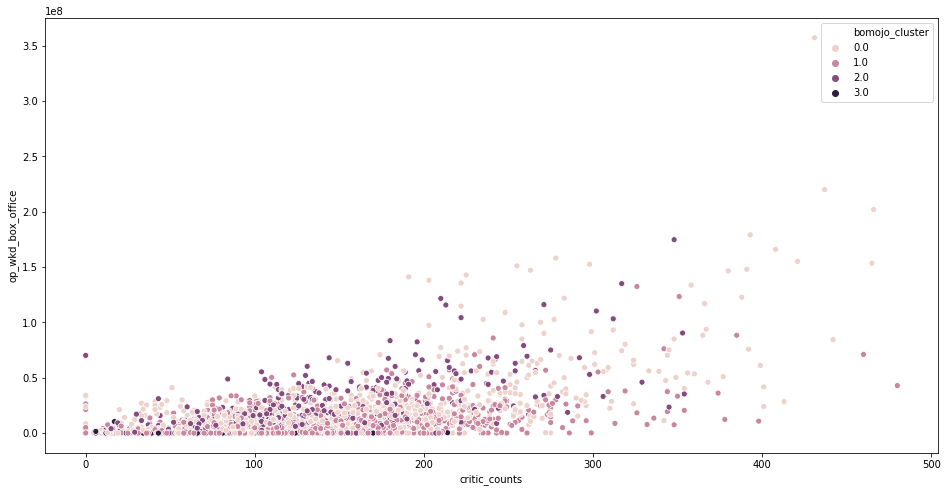

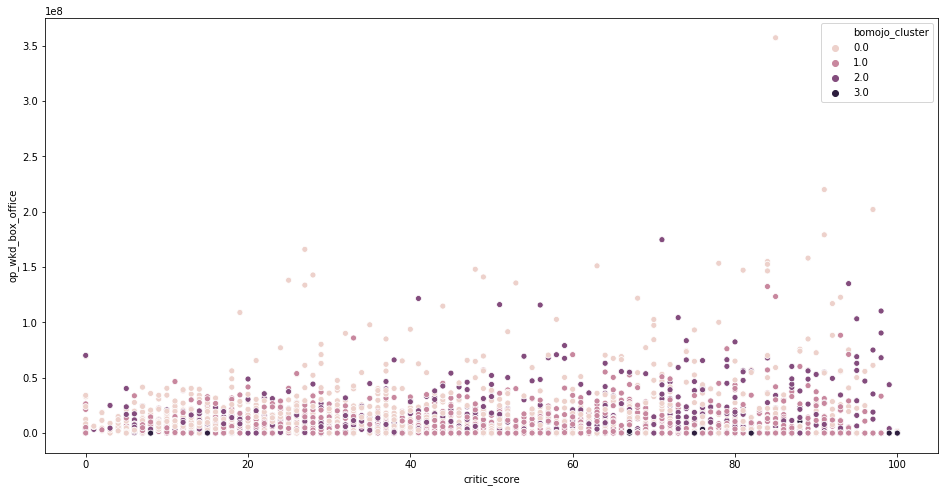

In [49]:
scatter_graph(df_bo_predictor,'critic_counts','op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,'critic_score','op_wkd_box_office','bomojo_cluster')

Unfortunately, the RottenTomatoes website changed during the time in which I was scraping the website and running this model so when re-running the scraping process to account for 10+ years, I lost all of the audience score and counts. In future iterations I will need to fix this bug. However, for the time being, the popularity component I am capturing from RottenTomatoes is still preserved in the critic scores, i.e. more popular movies that are likely to receive more box office or commercial success have more critic reviews.

RottenTomatoes audience and critic counts a way better relationship with opening weekend box office than score.

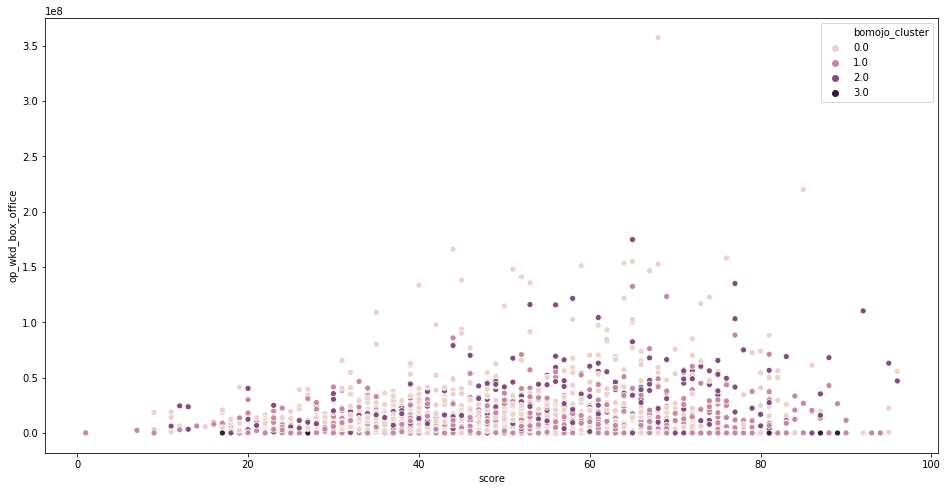

In [50]:
# mc score just like RT score doesn't seem as relevant
scatter_graph(df_bo_predictor,'score','op_wkd_box_office','bomojo_cluster')

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


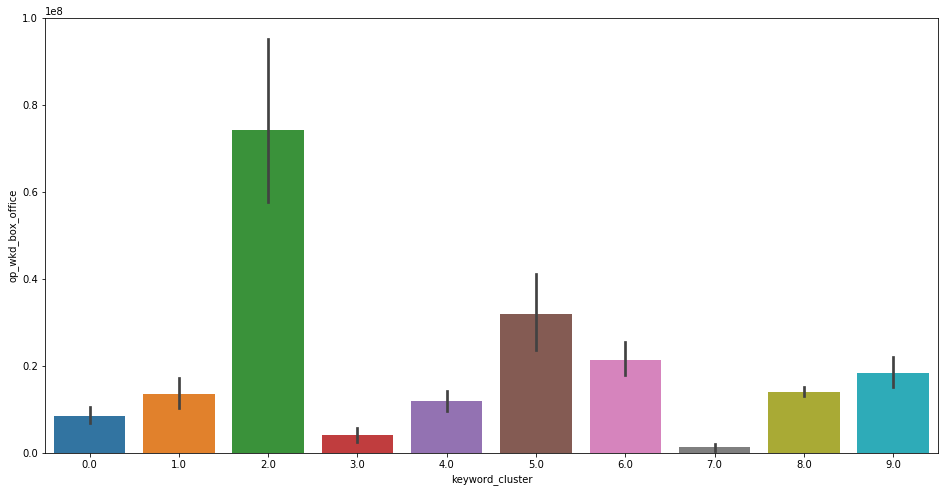

In [51]:
plt.figure(figsize=(16,8))
sns.barplot(x='keyword_cluster',y='op_wkd_box_office',data=df_bo_predictor)
plt.show()

### A quick look at film multiples

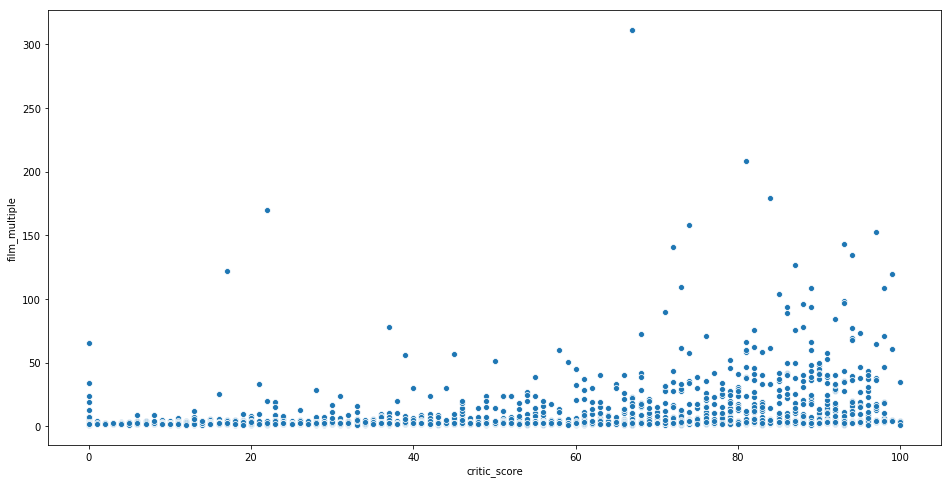

In [52]:
scatter_graph(df_bo_predictor,'critic_score','film_multiple',hue=None)

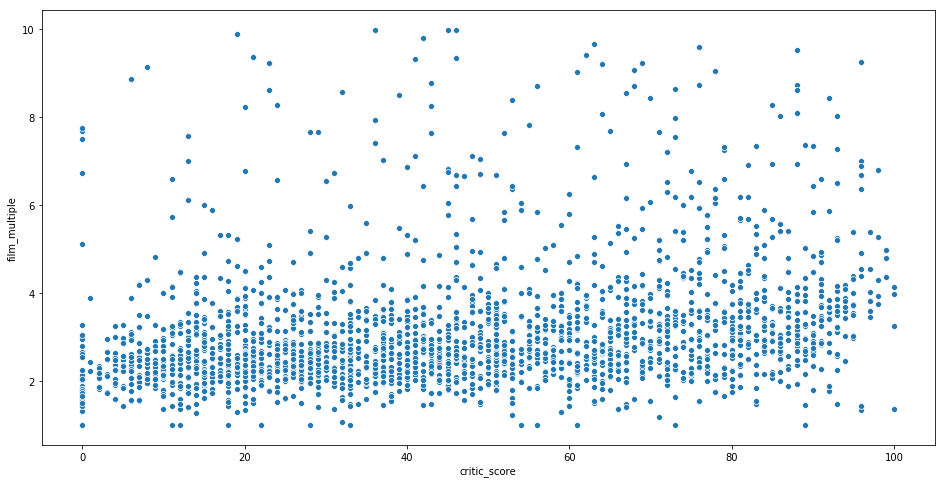

In [53]:
df_temp = df_bo_predictor[df_bo_predictor['film_multiple'] < 10]
scatter_graph(df_temp,'critic_score','film_multiple',None)

In [54]:
# scatterplot difficult to assess when overlapping points
# look at a density plot
# hist2D to discuss density and or hexbins  roundness in data
def hist2d_graph(x, y):
    plt.figure(figsize=(16,8))
    plt.hexbin(x=x,y=y,gridsize=(35,15))
    plt.show()

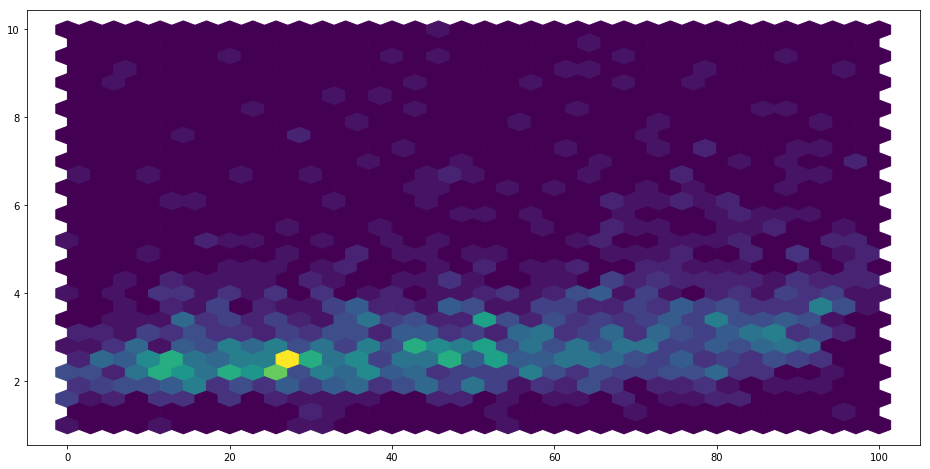

In [55]:
df_temp_temp = df_temp.dropna()
hist2d_graph(df_temp_temp['critic_score'],df_temp_temp['film_multiple'])

In [56]:
# validate with correlation coefficients above

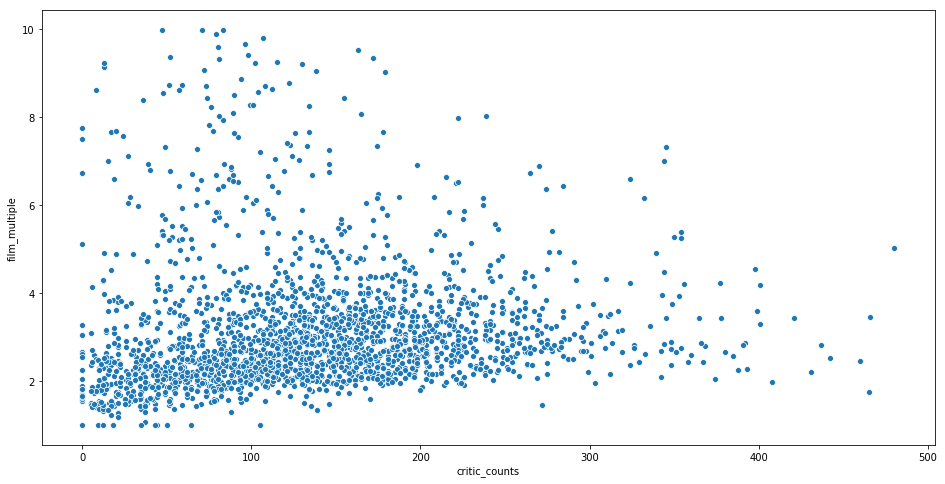

In [57]:
scatter_graph(df_temp,'critic_counts','film_multiple',None)

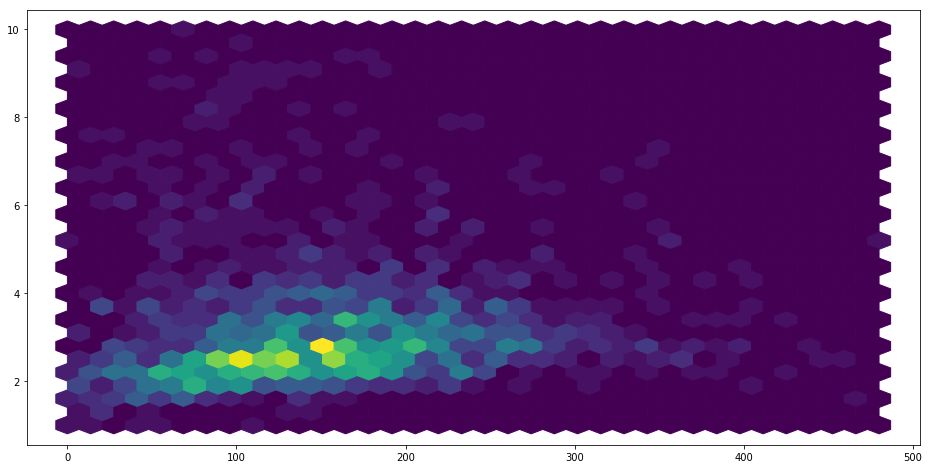

In [58]:
hist2d_graph(df_temp_temp['critic_counts'],df_temp_temp['film_multiple'])

In [59]:
df_temp_temp[['critic_counts','critic_score','film_multiple','op_wkd_box_office','dom_box_office']].corr()

,critic_counts,critic_score,film_multiple,op_wkd_box_office,dom_box_office
critic_counts,1.000000,0.479780,0.073978,0.594041,0.612082
critic_score,0.479780,1.000000,0.267462,0.221085,0.288238
film_multiple,0.073978,0.267462,1.000000,-0.033400,0.126933
op_wkd_box_office,0.594041,0.221085,-0.033400,1.000000,0.947549
dom_box_office,0.612082,0.288238,0.126933,0.947549,1.000000


In [60]:
df_temp_temp[['num_theaters','film_multiple','op_wkd_box_office','dom_box_office']].corr()

,num_theaters,film_multiple,op_wkd_box_office,dom_box_office
num_theaters,1.000000,-0.098778,0.600727,0.627560
film_multiple,-0.098778,1.000000,-0.033400,0.126933
op_wkd_box_office,0.600727,-0.033400,1.000000,0.947549
dom_box_office,0.627560,0.126933,0.947549,1.000000


In [61]:
# add in correlation for wiki pageviews and trailer views

A little cleanup before modeling:

In [62]:
df_bo_predictor = df_bo_predictor.drop(['budget','popularity','release_date_x','runtime','aud_counts','aud_score',
                                        'url_x','url_y','bomojo_url','num_theaters','release_date_y','title',
                                        'release_date_clean'],axis=1)
# df_bo_predictor_wpv = df_bo_predictor_wpv.drop(['title_x','title_y','release_date_y','genre','url_x','runtime',
#                                             'release_date_x','budget','url_y','bomojo_url','aud_counts',
#                                             'aud_score'],axis=1)

### Linear Regression model

In [63]:
# linear regression for box office results
df_model = df_bo_predictor.drop(['dom_box_office','film_multiple','log_op_wkd_box_office'],axis=1)
df_model = df_model.dropna()
X = df_model.drop('op_wkd_box_office',axis=1)
Y = df_model.op_wkd_box_office
X = pd.get_dummies(X)

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

In [65]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
print('R-squared: \n', lr.score(X_train, y_train))

Coefficients: 
 [-2.60993356e+06  4.35969031e+03 -3.21961156e+07  2.36782018e+07
  8.44489970e+08 -5.20103081e+08  4.95867610e+06 -1.71904986e+08
  3.29919441e+08 -8.77288037e+07  1.43291050e+08  8.62245544e+07
 -4.91046158e+08  3.16342800e+08 -6.11610903e+07  2.32700479e+08
  8.34223106e+07 -2.04743363e+08  4.47551777e+07 -1.98591244e+06
  2.06564028e+06  3.03205923e+06 -1.14837429e+06 -3.79026269e+05
  4.06532229e+06 -1.40104376e+06  1.83707266e+06 -9.93657817e+05
 -4.48911929e+05 -2.33468246e+06  1.92106258e+06 -3.31977412e+06
 -1.14001698e+06 -1.77263436e+06  2.27317214e-05  1.41894844e+06
  1.62981464e+06  1.00250321e+06 -5.43892384e-06 -1.54913217e+07
 -3.54383014e+06 -3.12709816e+06 -4.71615221e+06 -1.48266554e-05
  1.75141023e+05 -4.26278679e+06 -6.07998293e+06 -2.03505637e+06
 -2.92059285e+06 -3.04368812e+06 -3.09320112e+06  2.52574682e-06
 -4.24683094e-06  1.63763762e-05  5.81145287e-07  1.37090683e-06
 -2.42641814e+06 -2.60204396e+05  7.13020563e-06 -6.09531999e-05
  1.48192

In [66]:
y_pred = lr.predict(X_test)

print('Mean Absolute Error: %.f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 8734610
Mean Squared Error: 216165582932222
Root Mean Squared Error: 14702571
Median Absolute Error: 2328


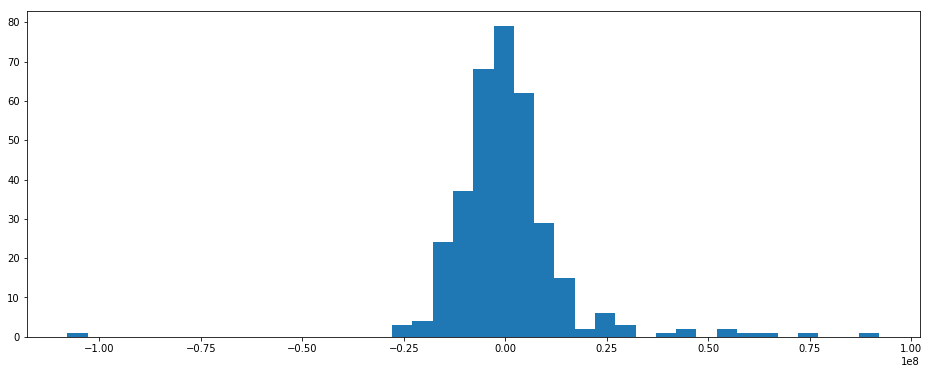

In [67]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=40)
plt.show()

In [68]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [69]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10       9.269196
0.20      21.869496
0.25      26.608930
0.50      58.158736
0.75     209.146280
0.80     566.009621
0.85    2653.993135
0.90    6742.065002
Name: difference %, dtype: float64

### Random Forest Regressor

In [70]:
rfr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
rfr.fit(X_train, y_train)
score = rfr.score(X_test, y_test)
print(f'Accuracy score for random forest regressor: {score}')

Accuracy score for random forest regressor: 0.7416755022957555


In [71]:
y_pred = rfr.predict(X_test)

print('Mean Absolute Error: %.f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 6836947
Mean Squared Error: 134750072507831
Root Mean Squared Error: 11608190
Median Absolute Error: 1915


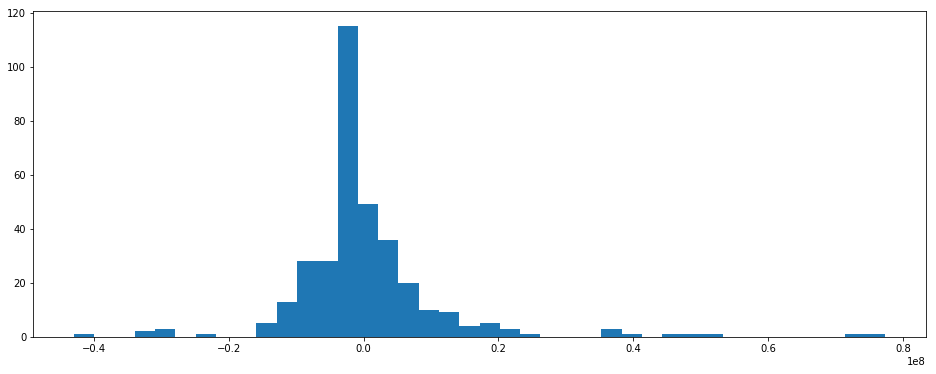

In [72]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=40)
plt.show()

In [73]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [74]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10       7.480104
0.20      14.649434
0.25      20.230871
0.50      43.286064
0.75     146.318137
0.80     874.810578
0.85    3537.164729
0.90    8665.077810
Name: difference %, dtype: float64

### NN

I am using the log of the opening weekend box office because of the mean absolute error loss function does not perform well with non-scaled output data. 

In [75]:
df_bo_predictor.shape

(3699, 150)

In [76]:
# linear regression for box office results
df_model = df_bo_predictor.drop(['dom_box_office','film_multiple','log_op_wkd_box_office'],axis=1)
df_model = df_model.dropna()

In [77]:
X = df_model.drop('op_wkd_box_office',axis=1)
Y = df_model.op_wkd_box_office
X = pd.get_dummies(X)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

In [79]:
# inputs first
input_shape = X_train.shape[1:]
num_classes = 1 # for regression problem

#### NOTES: 
- Elu does not do as well as relu as the activation function
- each additional layer added performs better, data does not take too long generally
- 10 epochs better than 5 epochs, 100 epochs better than 10 epochs

potentially try to use log_mean_absolute_error
benefit from more nodes in each layers
increase epochs until inflection point
learning rate and learning rate decay - fine tune how fast to train
by default rmsprop has learning rate of 0.1, lower the learning rate with RMSprop
using validation step inside of NN inside of train test split beforehand

In [379]:
from keras.layers import LeakyReLU, PReLU

model = Sequential()

model.add(Dense(128,input_shape=input_shape,activation='relu'))
model.add(PReLU(alpha_initializer='zeros'))
model.add(Dense(64, activation='elu'))
model.add(LeakyReLU(alpha=.03))
model.add(Dense(64, activation='elu'))
model.add(LeakyReLU(alpha=.03))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(num_classes, activation='linear'))

model.summary()
# Compile the model to put it all together.
model.compile(loss='mean_absolute_error',
              optimizer=RMSprop(lr=0.0005),
              metrics=['mean_absolute_error'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_551 (Dense)            (None, 128)               43520     
_________________________________________________________________
p_re_lu_21 (PReLU)           (None, 128)               128       
_________________________________________________________________
dense_552 (Dense)            (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_117 (LeakyReLU)  (None, 64)                0         
_________________________________________________________________
dense_553 (Dense)            (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_118 (LeakyReLU)  (None, 64)                0         
_________________________________________________________________
dense_554 (Dense)            (None, 64)                4160      
__________

In [380]:
history = model.fit(X.values, Y.values,
                    batch_size=16,
                    epochs=1000,
                    verbose=1,
                    validation_split=0.15,
                    shuffle=True)
score = model.evaluate(X.values, Y.values, verbose=0)

Train on 1453 samples, validate on 257 samples
Epoch 1/1000
1453/1453 [==============================] - 4s 3ms/step - loss: 12136275.1359 - mean_absolute_error: 12136275.1359 - val_loss: 10170553.8677 - val_mean_absolute_error: 10170553.8677
Epoch 2/1000
1453/1453 [==============================] - 1s 378us/step - loss: 9752523.5103 - mean_absolute_error: 9752523.5103 - val_loss: 10419309.5720 - val_mean_absolute_error: 10419309.5720
Epoch 3/1000
1453/1453 [==============================] - 1s 369us/step - loss: 9596166.2292 - mean_absolute_error: 9596166.2292 - val_loss: 9815683.9222 - val_mean_absolute_error: 9815683.9222
Epoch 4/1000
1453/1453 [==============================] - 1s 409us/step - loss: 9776691.3510 - mean_absolute_error: 9776691.3510 - val_loss: 9778770.4903 - val_mean_absolute_error: 9778770.4903
Epoch 5/1000
1453/1453 [==============================] - 1s 365us/step - loss: 9635284.9677 - mean_absolute_error: 9635284.9677 - val_loss: 9999806.8016 - val_mean_absolute

Epoch 43/1000
1453/1453 [==============================] - 1s 362us/step - loss: 8304739.8500 - mean_absolute_error: 8304739.8500 - val_loss: 8545277.0739 - val_mean_absolute_error: 8545277.0739
Epoch 44/1000
1453/1453 [==============================] - 1s 378us/step - loss: 8192811.1562 - mean_absolute_error: 8192811.1562 - val_loss: 8534706.4903 - val_mean_absolute_error: 8534706.4903
Epoch 45/1000
1453/1453 [==============================] - 1s 358us/step - loss: 8403141.0317 - mean_absolute_error: 8403141.0317 - val_loss: 8221520.1401 - val_mean_absolute_error: 8221520.1401
Epoch 46/1000
1453/1453 [==============================] - 1s 363us/step - loss: 8178899.5623 - mean_absolute_error: 8178899.5623 - val_loss: 8388172.1868 - val_mean_absolute_error: 8388172.1868
Epoch 47/1000
1453/1453 [==============================] - 1s 356us/step - loss: 8238786.0602 - mean_absolute_error: 8238786.0602 - val_loss: 8937068.1868 - val_mean_absolute_error: 8937068.1868
Epoch 48/1000
1453/1453 [

1453/1453 [==============================] - 1s 367us/step - loss: 7626181.2464 - mean_absolute_error: 7626181.2464 - val_loss: 7851226.6459 - val_mean_absolute_error: 7851226.6459
Epoch 86/1000
1453/1453 [==============================] - 1s 368us/step - loss: 7760648.2715 - mean_absolute_error: 7760648.2715 - val_loss: 8268916.1401 - val_mean_absolute_error: 8268916.1401
Epoch 87/1000
1453/1453 [==============================] - 1s 357us/step - loss: 7634205.8651 - mean_absolute_error: 7634205.8651 - val_loss: 7849130.5058 - val_mean_absolute_error: 7849130.5058
Epoch 88/1000
1453/1453 [==============================] - 1s 368us/step - loss: 7618825.0540 - mean_absolute_error: 7618825.0540 - val_loss: 7814804.2957 - val_mean_absolute_error: 7814804.2957
Epoch 89/1000
1453/1453 [==============================] - 1s 363us/step - loss: 7722827.8985 - mean_absolute_error: 7722827.8985 - val_loss: 7641926.2568 - val_mean_absolute_error: 7641926.2568
Epoch 90/1000
1453/1453 [==============

Epoch 127/1000
1453/1453 [==============================] - 1s 445us/step - loss: 7268530.3651 - mean_absolute_error: 7268530.3651 - val_loss: 7986814.4591 - val_mean_absolute_error: 7986814.4591
Epoch 128/1000
1453/1453 [==============================] - 1s 491us/step - loss: 7371350.4812 - mean_absolute_error: 7371350.4812 - val_loss: 7548109.8833 - val_mean_absolute_error: 7548109.8833
Epoch 129/1000
1453/1453 [==============================] - 1s 374us/step - loss: 7254692.8369 - mean_absolute_error: 7254692.8369 - val_loss: 7502534.6304 - val_mean_absolute_error: 7502534.6304
Epoch 130/1000
1453/1453 [==============================] - 1s 378us/step - loss: 7262470.6717 - mean_absolute_error: 7262470.6717 - val_loss: 7478670.5525 - val_mean_absolute_error: 7478670.5525
Epoch 131/1000
1453/1453 [==============================] - 1s 359us/step - loss: 7352596.7268 - mean_absolute_error: 7352596.7268 - val_loss: 7670238.6926 - val_mean_absolute_error: 7670238.6926
Epoch 132/1000
1453/

Epoch 169/1000
1453/1453 [==============================] - 1s 379us/step - loss: 6897925.6457 - mean_absolute_error: 6897925.6457 - val_loss: 7597648.5292 - val_mean_absolute_error: 7597648.5292
Epoch 170/1000
1453/1453 [==============================] - 1s 365us/step - loss: 7039043.1218 - mean_absolute_error: 7039043.1218 - val_loss: 7728563.7198 - val_mean_absolute_error: 7728563.7198
Epoch 171/1000
1453/1453 [==============================] - 1s 376us/step - loss: 7109493.9298 - mean_absolute_error: 7109493.9298 - val_loss: 7741109.7588 - val_mean_absolute_error: 7741109.7588
Epoch 172/1000
1453/1453 [==============================] - 1s 352us/step - loss: 6779618.2743 - mean_absolute_error: 6779618.2743 - val_loss: 8324226.8949 - val_mean_absolute_error: 8324226.8949
Epoch 173/1000
1453/1453 [==============================] - 1s 368us/step - loss: 6842062.1896 - mean_absolute_error: 6842062.1896 - val_loss: 8281915.5331 - val_mean_absolute_error: 8281915.5331
Epoch 174/1000
1453/

Epoch 211/1000
1453/1453 [==============================] - 1s 359us/step - loss: 6692817.5258 - mean_absolute_error: 6692817.5258 - val_loss: 7556946.7393 - val_mean_absolute_error: 7556946.7393
Epoch 212/1000
1453/1453 [==============================] - 1s 368us/step - loss: 6798047.0661 - mean_absolute_error: 6798047.0661 - val_loss: 7523870.8638 - val_mean_absolute_error: 7523870.8638
Epoch 213/1000
1453/1453 [==============================] - 1s 364us/step - loss: 6625664.2608 - mean_absolute_error: 6625664.2608 - val_loss: 7363806.1634 - val_mean_absolute_error: 7363806.1634
Epoch 214/1000
1453/1453 [==============================] - 1s 365us/step - loss: 6688609.0654 - mean_absolute_error: 6688609.0654 - val_loss: 8190894.4747 - val_mean_absolute_error: 8190894.4747
Epoch 215/1000
1453/1453 [==============================] - 1s 355us/step - loss: 6795760.0874 - mean_absolute_error: 6795760.0874 - val_loss: 9812261.6965 - val_mean_absolute_error: 9812261.6965
Epoch 216/1000
1453/

Epoch 253/1000
1453/1453 [==============================] - 1s 365us/step - loss: 6562034.3730 - mean_absolute_error: 6562034.3730 - val_loss: 7181251.9689 - val_mean_absolute_error: 7181251.9689
Epoch 254/1000
1453/1453 [==============================] - 1s 370us/step - loss: 6591977.4031 - mean_absolute_error: 6591977.4031 - val_loss: 7560586.4125 - val_mean_absolute_error: 7560586.4125
Epoch 255/1000
1453/1453 [==============================] - 1s 355us/step - loss: 6575960.0103 - mean_absolute_error: 6575960.0103 - val_loss: 7937865.1984 - val_mean_absolute_error: 7937865.1984
Epoch 256/1000
1453/1453 [==============================] - 1s 370us/step - loss: 6607362.9573 - mean_absolute_error: 6607362.9573 - val_loss: 7065779.9377 - val_mean_absolute_error: 7065779.9377
Epoch 257/1000
1453/1453 [==============================] - 1s 352us/step - loss: 6519841.5361 - mean_absolute_error: 6519841.5361 - val_loss: 7470877.5564 - val_mean_absolute_error: 7470877.5564
Epoch 258/1000
1453/

Epoch 295/1000
1453/1453 [==============================] - 1s 370us/step - loss: 6298077.7281 - mean_absolute_error: 6298077.7281 - val_loss: 9064434.4280 - val_mean_absolute_error: 9064434.4280
Epoch 296/1000
1453/1453 [==============================] - 1s 363us/step - loss: 6395974.1266 - mean_absolute_error: 6395974.1266 - val_loss: 7569730.1790 - val_mean_absolute_error: 7569730.1790
Epoch 297/1000
1453/1453 [==============================] - 1s 379us/step - loss: 6390705.5351 - mean_absolute_error: 6390705.5351 - val_loss: 7307838.0700 - val_mean_absolute_error: 7307838.0700
Epoch 298/1000
1453/1453 [==============================] - 1s 353us/step - loss: 6357081.4857 - mean_absolute_error: 6357081.4857 - val_loss: 7384695.1907 - val_mean_absolute_error: 7384695.1907
Epoch 299/1000
1453/1453 [==============================] - 1s 393us/step - loss: 6334909.8156 - mean_absolute_error: 6334909.8156 - val_loss: 6904925.0272 - val_mean_absolute_error: 6904925.0272
Epoch 300/1000
1453/

Epoch 337/1000
1453/1453 [==============================] - 1s 390us/step - loss: 6233852.6769 - mean_absolute_error: 6233852.6769 - val_loss: 7346691.4708 - val_mean_absolute_error: 7346691.4708
Epoch 338/1000
1453/1453 [==============================] - 1s 431us/step - loss: 6279141.7275 - mean_absolute_error: 6279141.7275 - val_loss: 7986264.7938 - val_mean_absolute_error: 7986264.7938
Epoch 339/1000
1453/1453 [==============================] - 1s 487us/step - loss: 6280775.9794 - mean_absolute_error: 6280775.9794 - val_loss: 7632037.5253 - val_mean_absolute_error: 7632037.5253
Epoch 340/1000
1453/1453 [==============================] - 1s 406us/step - loss: 6252478.4357 - mean_absolute_error: 6252478.4357 - val_loss: 7843948.5292 - val_mean_absolute_error: 7843948.5292
Epoch 341/1000
1453/1453 [==============================] - 1s 512us/step - loss: 6135536.8734 - mean_absolute_error: 6135536.8734 - val_loss: 6874028.0156 - val_mean_absolute_error: 6874028.0156
Epoch 342/1000
1453/

Epoch 379/1000
1453/1453 [==============================] - 1s 436us/step - loss: 5936859.4050 - mean_absolute_error: 5936859.4050 - val_loss: 8440959.2062 - val_mean_absolute_error: 8440959.2062
Epoch 380/1000
1453/1453 [==============================] - 1s 461us/step - loss: 5830357.6187 - mean_absolute_error: 5830357.6187 - val_loss: 7028539.7198 - val_mean_absolute_error: 7028539.7198
Epoch 381/1000
1453/1453 [==============================] - 1s 384us/step - loss: 5970083.1141 - mean_absolute_error: 5970083.1141 - val_loss: 7140672.1712 - val_mean_absolute_error: 7140672.1712
Epoch 382/1000
1453/1453 [==============================] - 1s 437us/step - loss: 6184153.0284 - mean_absolute_error: 6184153.0284 - val_loss: 7261067.6109 - val_mean_absolute_error: 7261067.6109
Epoch 383/1000
1453/1453 [==============================] - 1s 405us/step - loss: 5934328.8197 - mean_absolute_error: 5934328.8197 - val_loss: 7318531.2374 - val_mean_absolute_error: 7318531.2374
Epoch 384/1000
1453/

Epoch 421/1000
1453/1453 [==============================] - 1s 432us/step - loss: 6000794.5795 - mean_absolute_error: 6000794.5795 - val_loss: 8025874.8794 - val_mean_absolute_error: 8025874.8794
Epoch 422/1000
1453/1453 [==============================] - 1s 495us/step - loss: 5688335.3630 - mean_absolute_error: 5688335.3630 - val_loss: 7664961.3385 - val_mean_absolute_error: 7664961.3385
Epoch 423/1000
1453/1453 [==============================] - 1s 415us/step - loss: 5914991.5733 - mean_absolute_error: 5914991.5733 - val_loss: 6753933.1206 - val_mean_absolute_error: 6753933.1206
Epoch 424/1000
1453/1453 [==============================] - 1s 403us/step - loss: 5879380.9260 - mean_absolute_error: 5879380.9260 - val_loss: 8027894.7237 - val_mean_absolute_error: 8027894.7237
Epoch 425/1000
1453/1453 [==============================] - 1s 470us/step - loss: 5859771.8359 - mean_absolute_error: 5859771.8359 - val_loss: 7372797.1362 - val_mean_absolute_error: 7372797.1362
Epoch 426/1000
1453/

Epoch 463/1000
1453/1453 [==============================] - 1s 448us/step - loss: 5740235.9952 - mean_absolute_error: 5740235.9952 - val_loss: 7547627.4241 - val_mean_absolute_error: 7547627.4241
Epoch 464/1000
1453/1453 [==============================] - 1s 445us/step - loss: 5862939.3314 - mean_absolute_error: 5862939.3314 - val_loss: 8610078.2101 - val_mean_absolute_error: 8610078.2101
Epoch 465/1000
1453/1453 [==============================] - 1s 405us/step - loss: 5810287.2368 - mean_absolute_error: 5810287.2368 - val_loss: 7045264.0156 - val_mean_absolute_error: 7045264.0156
Epoch 466/1000
1453/1453 [==============================] - 1s 469us/step - loss: 5653776.7615 - mean_absolute_error: 5653776.7615 - val_loss: 7115929.9455 - val_mean_absolute_error: 7115929.9455
Epoch 467/1000
1453/1453 [==============================] - 1s 387us/step - loss: 5848542.5003 - mean_absolute_error: 5848542.5003 - val_loss: 7227688.5603 - val_mean_absolute_error: 7227688.5603
Epoch 468/1000
1453/

Epoch 505/1000
1453/1453 [==============================] - 1s 454us/step - loss: 5579375.7426 - mean_absolute_error: 5579375.7426 - val_loss: 6855437.8210 - val_mean_absolute_error: 6855437.8210
Epoch 506/1000
1453/1453 [==============================] - 1s 420us/step - loss: 5633755.2319 - mean_absolute_error: 5633755.2319 - val_loss: 7571210.0545 - val_mean_absolute_error: 7571210.0545
Epoch 507/1000
1453/1453 [==============================] - 1s 418us/step - loss: 5706539.1177 - mean_absolute_error: 5706539.1177 - val_loss: 7621771.1128 - val_mean_absolute_error: 7621771.1128
Epoch 508/1000
1453/1453 [==============================] - 1s 482us/step - loss: 5559406.5485 - mean_absolute_error: 5559406.5485 - val_loss: 6912030.4591 - val_mean_absolute_error: 6912030.4591
Epoch 509/1000
1453/1453 [==============================] - 1s 437us/step - loss: 5633620.0812 - mean_absolute_error: 5633620.0812 - val_loss: 7800859.0661 - val_mean_absolute_error: 7800859.0661
Epoch 510/1000
1453/

Epoch 547/1000
1453/1453 [==============================] - 1s 419us/step - loss: 5524671.7312 - mean_absolute_error: 5524671.7312 - val_loss: 7325473.1829 - val_mean_absolute_error: 7325473.1829
Epoch 548/1000
1453/1453 [==============================] - 1s 476us/step - loss: 5680023.7423 - mean_absolute_error: 5680023.7423 - val_loss: 6757152.4047 - val_mean_absolute_error: 6757152.4047
Epoch 549/1000
1453/1453 [==============================] - 1s 426us/step - loss: 5511162.0891 - mean_absolute_error: 5511162.0891 - val_loss: 7861633.4475 - val_mean_absolute_error: 7861633.4475
Epoch 550/1000
1453/1453 [==============================] - 1s 410us/step - loss: 5623537.8180 - mean_absolute_error: 5623537.8180 - val_loss: 7639150.1790 - val_mean_absolute_error: 7639150.1790
Epoch 551/1000
1453/1453 [==============================] - 1s 479us/step - loss: 5328098.6924 - mean_absolute_error: 5328098.6924 - val_loss: 7093993.3230 - val_mean_absolute_error: 7093993.3230
Epoch 552/1000
1453/

Epoch 589/1000
1453/1453 [==============================] - 1s 403us/step - loss: 5492732.5036 - mean_absolute_error: 5492732.5036 - val_loss: 6873203.8755 - val_mean_absolute_error: 6873203.8755
Epoch 590/1000
1453/1453 [==============================] - 1s 478us/step - loss: 5192854.9835 - mean_absolute_error: 5192854.9835 - val_loss: 8706972.2646 - val_mean_absolute_error: 8706972.2646
Epoch 591/1000
1453/1453 [==============================] - 1s 390us/step - loss: 5373934.8011 - mean_absolute_error: 5373934.8011 - val_loss: 7152418.7393 - val_mean_absolute_error: 7152418.7393
Epoch 592/1000
1453/1453 [==============================] - 1s 408us/step - loss: 5270388.3362 - mean_absolute_error: 5270388.3362 - val_loss: 7407954.5525 - val_mean_absolute_error: 7407954.5525
Epoch 593/1000
1453/1453 [==============================] - 1s 470us/step - loss: 5358974.1003 - mean_absolute_error: 5358974.1003 - val_loss: 7349181.3230 - val_mean_absolute_error: 7349181.3230
Epoch 594/1000
1453/

Epoch 631/1000
1453/1453 [==============================] - 1s 432us/step - loss: 5050720.2529 - mean_absolute_error: 5050720.2529 - val_loss: 7279924.2335 - val_mean_absolute_error: 7279924.2335
Epoch 632/1000
1453/1453 [==============================] - 1s 392us/step - loss: 5401860.4659 - mean_absolute_error: 5401860.4659 - val_loss: 7842208.7626 - val_mean_absolute_error: 7842208.7626
Epoch 633/1000
1453/1453 [==============================] - 1s 502us/step - loss: 5280360.5299 - mean_absolute_error: 5280360.5299 - val_loss: 7673317.2140 - val_mean_absolute_error: 7673317.2140
Epoch 634/1000
1453/1453 [==============================] - 1s 460us/step - loss: 5214878.1493 - mean_absolute_error: 5214878.1493 - val_loss: 7004637.5097 - val_mean_absolute_error: 7004637.5097
Epoch 635/1000
1453/1453 [==============================] - 1s 406us/step - loss: 5385844.2939 - mean_absolute_error: 5385844.2939 - val_loss: 7335668.0156 - val_mean_absolute_error: 7335668.0156
Epoch 636/1000
1453/

Epoch 673/1000
1453/1453 [==============================] - 1s 433us/step - loss: 5015215.2374 - mean_absolute_error: 5015215.2374 - val_loss: 7315844.9494 - val_mean_absolute_error: 7315844.9494
Epoch 674/1000
1453/1453 [==============================] - 1s 400us/step - loss: 5081949.0337 - mean_absolute_error: 5081949.0337 - val_loss: 6750758.4903 - val_mean_absolute_error: 6750758.4903
Epoch 675/1000
1453/1453 [==============================] - 1s 455us/step - loss: 4972993.6290 - mean_absolute_error: 4972993.6290 - val_loss: 7213776.2335 - val_mean_absolute_error: 7213776.2335
Epoch 676/1000
1453/1453 [==============================] - 1s 395us/step - loss: 5048029.8897 - mean_absolute_error: 5048029.8897 - val_loss: 7195231.8444 - val_mean_absolute_error: 7195231.8444
Epoch 677/1000
1453/1453 [==============================] - 1s 475us/step - loss: 5165129.0833 - mean_absolute_error: 5165129.0833 - val_loss: 7047581.7588 - val_mean_absolute_error: 7047581.7588
Epoch 678/1000
1453/

Epoch 715/1000
1453/1453 [==============================] - 1s 509us/step - loss: 4777806.1967 - mean_absolute_error: 4777806.1967 - val_loss: 7296162.1634 - val_mean_absolute_error: 7296162.1634
Epoch 716/1000
1453/1453 [==============================] - 1s 583us/step - loss: 5032701.1213 - mean_absolute_error: 5032701.1213 - val_loss: 7256492.0467 - val_mean_absolute_error: 7256492.0467
Epoch 717/1000
1453/1453 [==============================] - 1s 533us/step - loss: 4989836.9270 - mean_absolute_error: 4989836.9270 - val_loss: 7807938.5837 - val_mean_absolute_error: 7807938.5837
Epoch 718/1000
1453/1453 [==============================] - 1s 475us/step - loss: 4936402.5420 - mean_absolute_error: 4936402.5420 - val_loss: 6898386.6148 - val_mean_absolute_error: 6898386.6148
Epoch 719/1000
1453/1453 [==============================] - 1s 463us/step - loss: 4783892.7834 - mean_absolute_error: 4783892.7834 - val_loss: 7131045.9144 - val_mean_absolute_error: 7131045.9144
Epoch 720/1000
1453/

Epoch 757/1000
1453/1453 [==============================] - 1s 438us/step - loss: 4764321.9260 - mean_absolute_error: 4764321.9260 - val_loss: 7323788.9339 - val_mean_absolute_error: 7323788.9339
Epoch 758/1000
1453/1453 [==============================] - 1s 383us/step - loss: 4812966.5423 - mean_absolute_error: 4812966.5423 - val_loss: 7244304.7782 - val_mean_absolute_error: 7244304.7782
Epoch 759/1000
1453/1453 [==============================] - 1s 428us/step - loss: 4907201.9350 - mean_absolute_error: 4907201.9350 - val_loss: 6935023.3463 - val_mean_absolute_error: 6935023.3463
Epoch 760/1000
1453/1453 [==============================] - 1s 471us/step - loss: 4934846.0413 - mean_absolute_error: 4934846.0413 - val_loss: 7801248.6070 - val_mean_absolute_error: 7801248.6070
Epoch 761/1000
1453/1453 [==============================] - 1s 408us/step - loss: 4845589.3472 - mean_absolute_error: 4845589.3472 - val_loss: 7328779.0506 - val_mean_absolute_error: 7328779.0506
Epoch 762/1000
1453/

Epoch 799/1000
1453/1453 [==============================] - 1s 449us/step - loss: 4631664.6015 - mean_absolute_error: 4631664.6015 - val_loss: 7317636.8249 - val_mean_absolute_error: 7317636.8249
Epoch 800/1000
1453/1453 [==============================] - 1s 401us/step - loss: 4764924.5408 - mean_absolute_error: 4764924.5408 - val_loss: 7487436.6848 - val_mean_absolute_error: 7487436.6848
Epoch 801/1000
1453/1453 [==============================] - 1s 478us/step - loss: 4857349.6514 - mean_absolute_error: 4857349.6514 - val_loss: 7225534.8638 - val_mean_absolute_error: 7225534.8638
Epoch 802/1000
1453/1453 [==============================] - 1s 429us/step - loss: 4747076.5654 - mean_absolute_error: 4747076.5654 - val_loss: 7385962.1479 - val_mean_absolute_error: 7385962.1479
Epoch 803/1000
1453/1453 [==============================] - 1s 408us/step - loss: 4699118.5062 - mean_absolute_error: 4699118.5062 - val_loss: 7891139.9844 - val_mean_absolute_error: 7891139.9844
Epoch 804/1000
1453/

Epoch 841/1000
1453/1453 [==============================] - 1s 406us/step - loss: 4554747.6531 - mean_absolute_error: 4554747.6531 - val_loss: 7823027.1440 - val_mean_absolute_error: 7823027.1440
Epoch 842/1000
1453/1453 [==============================] - 1s 452us/step - loss: 4570161.6827 - mean_absolute_error: 4570161.6827 - val_loss: 7287662.0233 - val_mean_absolute_error: 7287662.0233
Epoch 843/1000
1453/1453 [==============================] - 1s 574us/step - loss: 4680541.1504 - mean_absolute_error: 4680541.1504 - val_loss: 8595962.7549 - val_mean_absolute_error: 8595962.7549
Epoch 844/1000
1453/1453 [==============================] - 1s 568us/step - loss: 4646079.7564 - mean_absolute_error: 4646079.7564 - val_loss: 7493042.3658 - val_mean_absolute_error: 7493042.3658
Epoch 845/1000
1453/1453 [==============================] - 1s 518us/step - loss: 4465883.7065 - mean_absolute_error: 4465883.7065 - val_loss: 7854350.9416 - val_mean_absolute_error: 7854350.9416
Epoch 846/1000
1453/

Epoch 883/1000
1453/1453 [==============================] - 1s 528us/step - loss: 4493264.9928 - mean_absolute_error: 4493264.9928 - val_loss: 7212611.4241 - val_mean_absolute_error: 7212611.4241
Epoch 884/1000
1453/1453 [==============================] - 1s 463us/step - loss: 4289298.7978 - mean_absolute_error: 4289298.7978 - val_loss: 7555807.0039 - val_mean_absolute_error: 7555807.0039
Epoch 885/1000
1453/1453 [==============================] - 1s 386us/step - loss: 4375338.5629 - mean_absolute_error: 4375338.5629 - val_loss: 7406805.1829 - val_mean_absolute_error: 7406805.1829
Epoch 886/1000
1453/1453 [==============================] - 1s 408us/step - loss: 4528085.6487 - mean_absolute_error: 4528085.6487 - val_loss: 7519403.7043 - val_mean_absolute_error: 7519403.7043
Epoch 887/1000
1453/1453 [==============================] - 1s 439us/step - loss: 4484264.5668 - mean_absolute_error: 4484264.5668 - val_loss: 7421339.3774 - val_mean_absolute_error: 7421339.3774
Epoch 888/1000
1453/

Epoch 925/1000
1453/1453 [==============================] - 1s 531us/step - loss: 4400650.0265 - mean_absolute_error: 4400650.0265 - val_loss: 7809403.6887 - val_mean_absolute_error: 7809403.6887
Epoch 926/1000
1453/1453 [==============================] - 1s 544us/step - loss: 4497493.0468 - mean_absolute_error: 4497493.0468 - val_loss: 7888253.8988 - val_mean_absolute_error: 7888253.8988
Epoch 927/1000
1453/1453 [==============================] - 1s 509us/step - loss: 4272920.5804 - mean_absolute_error: 4272920.5804 - val_loss: 7247328.3268 - val_mean_absolute_error: 7247328.3268
Epoch 928/1000
1453/1453 [==============================] - 1s 444us/step - loss: 4325548.0482 - mean_absolute_error: 4325548.0482 - val_loss: 7708142.9105 - val_mean_absolute_error: 7708142.9105
Epoch 929/1000
1453/1453 [==============================] - 1s 421us/step - loss: 4445841.3063 - mean_absolute_error: 4445841.3063 - val_loss: 7342184.2490 - val_mean_absolute_error: 7342184.2490
Epoch 930/1000
1453/

Epoch 967/1000
1453/1453 [==============================] - 1s 422us/step - loss: 4440984.2884 - mean_absolute_error: 4440984.2884 - val_loss: 7949361.7121 - val_mean_absolute_error: 7949361.7121
Epoch 968/1000
1453/1453 [==============================] - 1s 383us/step - loss: 4295142.1714 - mean_absolute_error: 4295142.1714 - val_loss: 8059446.3502 - val_mean_absolute_error: 8059446.3502
Epoch 969/1000
1453/1453 [==============================] - 1s 394us/step - loss: 4344824.5112 - mean_absolute_error: 4344824.5112 - val_loss: 7687239.8444 - val_mean_absolute_error: 7687239.8444
Epoch 970/1000
1453/1453 [==============================] - 1s 409us/step - loss: 4181546.5471 - mean_absolute_error: 4181546.5471 - val_loss: 8035731.6420 - val_mean_absolute_error: 8035731.6420
Epoch 971/1000
1453/1453 [==============================] - 1s 445us/step - loss: 4433199.1652 - mean_absolute_error: 4433199.1652 - val_loss: 7371232.4514 - val_mean_absolute_error: 7371232.4514
Epoch 972/1000
1453/

In [381]:
print('Test loss: %0.1f' % score[0])
print('Test metric: %0.1f' % score[1])
# print('Non-log test loss: %0.f' % (score[0] ** 10) )
# print('Non-log test metric: %0.f' %  (score[1] ** 10))

Test loss: 4192216.2
Test metric: 4192216.2


In [382]:
y_pred = model.predict(X.values)
residuals = y_pred.ravel() - Y.values
abs(residuals).mean()

4192216.1975280405

In [383]:
print('Mean Absolute Error: %.f' % metrics.mean_absolute_error(Y, y_pred))  
print('Mean Squared Error: %.f' % metrics.mean_squared_error(Y, y_pred))  
print('Root Mean Squared Error: %.f' % np.sqrt(metrics.mean_squared_error(Y, y_pred)))
print('Median Absolute Error: %.f' % np.sqrt(metrics.median_absolute_error(Y, y_pred)))

Mean Absolute Error: 4192216
Mean Squared Error: 106859566891830
Root Mean Squared Error: 10337290
Median Absolute Error: 1018


Mean absolute error:
- First iteration (500 epochs): 5.9417M
- Iteration with adding (1) leakyrelu(a=0.05) (500 epochs): 6.1690M
- Iteration with adding (1) leakyrelu(a=0.03) (500 epochs): 5.6956M
- Iteration with adding (1) leakyrelu(a=0.01) (500 epochs): 6.0189M

- Iteration with adding (2) leakyrelu(a=0.03) (500 epochs): 7.7714M
- Iteration with adding (2) leakyrelu(a=0.03) (500 epochs): 6.6204M (but one of the dense layers in between)
- Iteration with adding (2) leakyrelu(a=0.03) (500 epochs): 5.793269M (more in beginning, still  one of the dense layers in between)
- Iteration with adding (2) leakyrelu(a=0.03) (500 epochs): 5.8362M (but one at beginning and end)

- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 7.1531M (beginning, middle, emd)
- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 5.9396M (all together beginning)
- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 5.7035M (all together beginning, earlier right after start)
- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 6.7081M (all together middle)
- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 7.0383M (all together end)
- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 6.1330M (beginning, with dense layers in between)

- Iteration with adding (4) leakyrelu(a=0.03) (500 epochs): 5.9501M (all at beginning)
- Iteration with adding (4) leakyrelu(a=0.03) (500 epochs): 6.0538M (2 at beginning, 1 dense layer, 2 after that)
- Iteration with adding (4) leakyrelu(a=0.03) (500 epochs): 7.1631M (2 at beginning, 2 in middle)
- Iteration with adding (4) leakyrelu(a=0.03) (500 epochs): 6.5951M (2 at beginning, 2 at end)

- Iteration with adding (6) leakyrelu(a=0.03) (500 epochs): 6.2873M (all at beginning right after start)
- Iteration with all (10) leakyrelu(a=0.03) (500 epochs): 9.5614M 
- Iteration with (10) leakyrelu(a=0.03) (500 epochs): 6.3074M (all at beginning) 

- Iteration with (1) leakyrelu(a=0.03) and (1) PReLU (500 epochs): 5.6511M (dense layer between, PReLU first) 
- Iteration with (1) leakyrelu(a=0.03) and (1) PReLU (1000 epochs): 5.1120 (dense layer between, PReLU first) 
- Iteration with (1) leakyrelu(a=0.03) (1000 epochs): 5.0712M (leakyrelu first) 
- Iteration with (1) leakyrelu(a=0.03) (1000 epochs): 4.8158M (leakyrelu first and 2 more dense layers) 
- Iteration with (1) leakyrelu(a=0.03) (1000 epochs): 4.518326M (leakyrelu first and 3 more dense layers (64 nodes)) 
- Iteration with (1) leakyrelu(a=0.03) (1000 epochs): 4.018532M (leakyrelu first and 3 more dense layers (64 nodes)) 
- Iteration with (1) leakyrelu(a=0.03) (1000 epochs): 4.0966M (leakyrelu first and 3 more dense layers (64 nodes)) 

- Removed a few dense layers, now at 4.4709M, trying to get back to just over 4M
- back to 4.358M and ~18% off on 50% of predictions (one iteration went as far as ~16% off for 50%). Still worried about overfitting looking at the validation mean absolute errors on the epoch verbose print outs.

- added a few more dense layers with 64 nodes and error down to ~3.8M with 50% of predictions within 15% of actuals

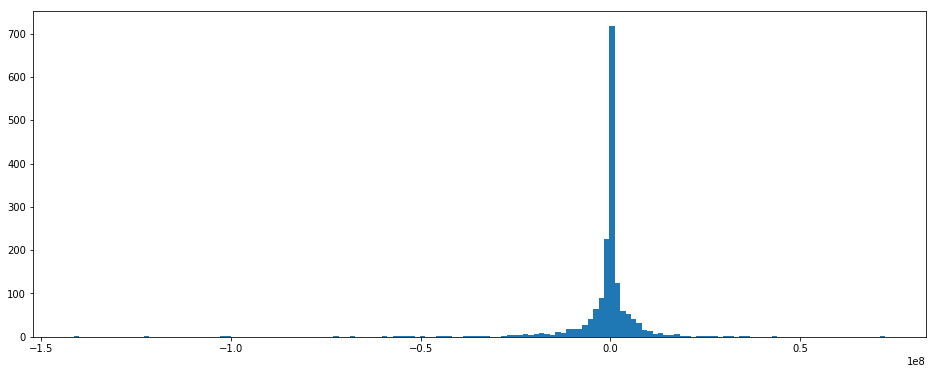

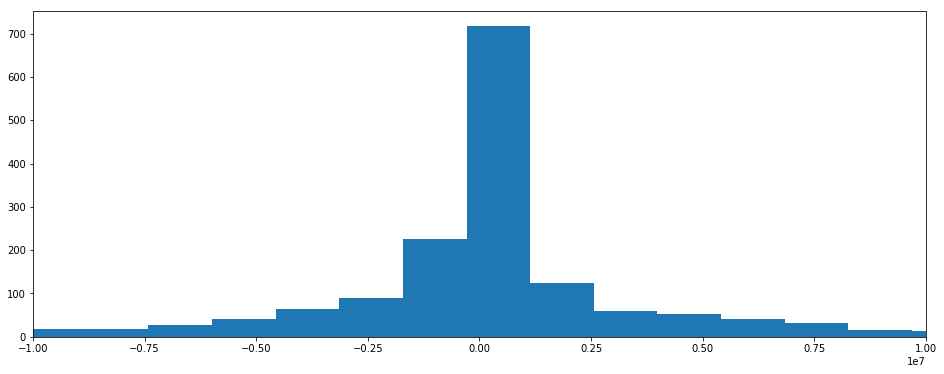

In [384]:
plt.figure(figsize=(16,6))
plt.hist(residuals, bins=150)
plt.show()
plt.figure(figsize=(16,6))
plt.hist(residuals, bins=150)
plt.xlim(-10000000,10000000)
plt.show()

In [385]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice': Y.values,
                          'predicted_boxoffice':y_pred.ravel()},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [386]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10     2.611118
0.20     5.168029
0.25     7.098711
0.50    18.896821
0.75    44.173332
0.80    53.282091
0.85    66.068289
0.90    86.576345
Name: difference %, dtype: float64

## Film Multiple model
### Linear regression to predict film multiple

In [387]:
# linear regression for box office results
df_model = df_bo_predictor.drop(['dom_box_office','op_wkd_box_office','log_op_wkd_box_office'],axis=1)
df_model = df_model.dropna()
X = df_model.drop('film_multiple',axis=1)
Y = df_model.film_multiple
X = pd.get_dummies(X)

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

In [389]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
print('R-squared: \n', lr.score(X_train, y_train))

Coefficients: 
 [ 1.06376122e+00 -2.87683260e-04 -2.45227870e-01 -7.29636546e+00
  5.58155037e+01 -2.11382432e+02  5.30270118e+01  2.11483839e+01
  7.82858271e+01 -1.12605928e+02  8.00106822e+01  4.10990446e+00
  3.66370053e+01 -4.82141059e+01  1.59299111e+01 -1.98729445e+01
 -1.17770806e+02  2.29670212e+02 -1.80989130e+02  7.24722825e-01
  1.37379266e+00  1.78818238e+00 -1.48655423e+00 -5.73213106e-01
 -5.18500294e+00 -3.45879683e-01 -2.88696470e-01  1.05670846e+00
  9.13186564e-01  5.55834015e-01  3.38574947e+00 -1.02876167e+00
  2.23480575e+00 -1.16891884e+00  1.71098691e-11 -1.34500630e+00
 -1.61544400e+00 -5.89230480e+00  1.03916875e-11  9.81530854e+00
 -6.25737985e-02  5.70709708e+01  4.85145387e+00 -8.15347789e-13
  8.43246119e+00  3.28354481e+00  9.71363935e-01  1.25560814e+00
 -4.34360820e+00  3.91069510e+00  7.68959900e+00 -7.19690973e-12
 -2.66897615e-12 -5.44631007e-12 -8.50697290e-12 -4.50839366e-12
 -3.62829367e+00 -1.64381624e+00  5.43742829e-12  4.82103246e-12
 -3.02335

In [390]:
y_pred = lr.predict(X_test)

print('Mean Absolute Error: %.3f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.3f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.3f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 6.499
Mean Squared Error: 134.442
Root Mean Squared Error: 11.595
Median Absolute Error: 1.819


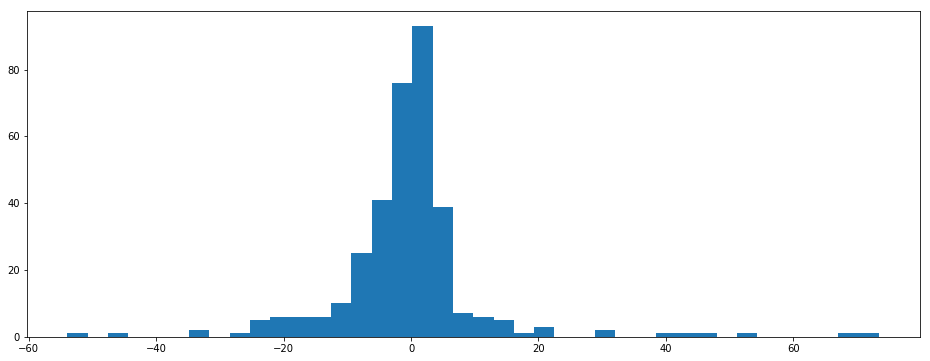

In [391]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=40)
plt.show()

In [392]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [393]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10     12.842134
0.20     27.268289
0.25     39.679104
0.50     93.191703
0.75    186.917318
0.80    219.193930
0.85    310.978729
0.90    446.074789
Name: difference %, dtype: float64

### Random Forest Regressor

In [394]:
rfr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
rfr.fit(X_train, y_train)
score = rfr.score(X_test, y_test)
print(f'Accuracy score for random forest regressor: {score}')

Accuracy score for random forest regressor: 0.40426385200792525


In [395]:
y_pred = rfr.predict(X_test)

print('Mean Absolute Error: %.3f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.3f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.3f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 3.340
Mean Squared Error: 65.810
Root Mean Squared Error: 8.112
Median Absolute Error: 0.841


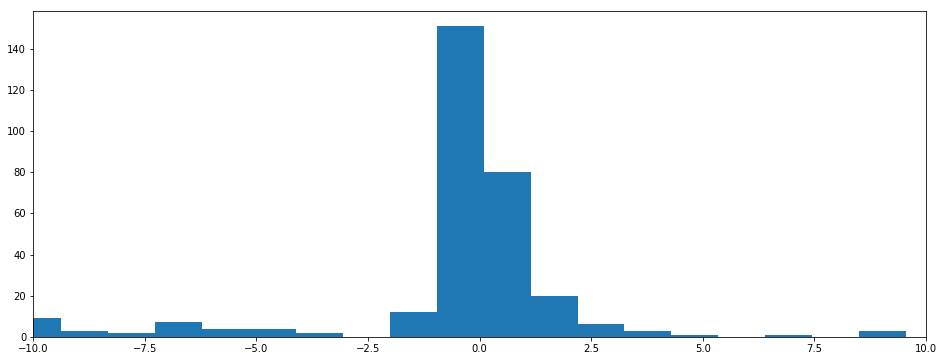

In [396]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=100)
plt.xlim([-10,10])
plt.show()

In [397]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [398]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10      3.789600
0.20      9.288465
0.25     11.349683
0.50     21.921594
0.75     41.977535
0.80     48.152205
0.85     62.491412
0.90    112.970440
Name: difference %, dtype: float64